# Working with the cleaned Dataset by Stefan

In [1]:
#importing necessary libaries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

import emoji
import demoji
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import csv
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation, Flatten
from keras.models import Sequential
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim

df = pd.read_csv("phones_full_clean_final.csv", sep=";")

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulabeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Product Name,Brand Name,Price,Stars,Text,Review Votes,AverageRating,ReviewsNumber,bayesian_avg,sentiment
0,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,good,0,40,3,"3,62394E+15",Positive
1,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,Fantastic product.,0,40,3,"3,62394E+15",Positive
2,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,2,The camera is big disappointment on many level...,0,40,3,"3,62394E+15",Negative
3,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,ACER,129.99,1,"The description says 16GB rom, it only has 8GB...",0,15,2,"3,5928E+15",Negative
4,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,ACER,129.99,2,I had high hopes for this Acer phone based the...,0,15,2,"3,5928E+15",Negative


In [2]:
#looking for duplicated rows
n_rows_duplicated = df.duplicated().sum()

print("Number of duplicated rows:", n_rows_duplicated)

#dropping the duplicated rows
df.drop_duplicates(inplace=True)

#checking if duplcated rows were dropped
n_rows_duplicated = df.duplicated().sum()
print("Number of duplicated rows:", n_rows_duplicated)

Number of duplicated rows: 318
Number of duplicated rows: 0


In [3]:
#We dropped the columns AverageRating and Bayesian Average as they are not relevant for the predictions 
df.drop('AverageRating', axis=1, inplace=True)
df.drop('bayesian_avg', axis=1, inplace=True)

In [4]:
#Adding columns with the average number of Stars given 
#and a column with the amount of Reviews for each unique 'Product Name'
aggregation = {"Stars": "mean",
               "Text": "count"}

phones = df.groupby(["Product Name"]).agg(aggregation).sort_values(by=['Text'], ascending=False).reset_index()
phones

,Product Name,Stars,Text
0,Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP...,3.323409,974
1,Apple MF259LL/A - iPhone 4s 8GB / 8MP Camera -...,3.314678,947
2,Apple iPhone 4S 16GB Unlocked GSM - White (Cer...,3.327113,911
3,Apple iPhone 4S 32GB Unlocked GSM Smartphone w...,3.331058,879
4,Apple iPhone 5s 32GB (Silver) - AT&T,3.928246,878
...,...,...,...
4289,Nokia N81 2gb Unlocked GSM Quad-band Cell Phone,5.000000,1
4290,Nokia N73 Unlocked Genuine Smart Music Mobile ...,1.000000,1
4291,Nokia N70 Black Unlocked Music Edition Triband...,5.000000,1
4292,Lenovo K910 VIBE Z Unlocked Smartphone 3G 5.5 ...,5.000000,1


In [5]:
#adding previously created columns to the Dataframe
df = df.merge(phones, on='Product Name')
df.head(10)

,Product Name,Brand Name,Price,Stars_x,Text_x,Review Votes,ReviewsNumber,sentiment,Stars_y,Text_y
0,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,good,0,3,Positive,4.0,3
1,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,Fantastic product.,0,3,Positive,4.0,3
2,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,2,The camera is big disappointment on many level...,0,3,Negative,4.0,3
3,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,ACER,129.99,1,"The description says 16GB rom, it only has 8GB...",0,2,Negative,1.5,2
4,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,ACER,129.99,2,I had high hopes for this Acer phone based the...,0,2,Negative,1.5,2
5,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,3,"this phone was a replacement for my niece, her...",40,15,Neutral,3.2,15
6,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,5,Dual Sims are better than one sim has blurred ...,20,15,Positive,3.2,15
7,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,5,Nice phone. I am waiting to be upgraded to Win...,20,15,Positive,3.2,15
8,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,1,I did not receive my order items.,0,15,Negative,3.2,15
9,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,1,"First off, great service as usual. I wanted a ...",50,15,Negative,3.2,15


In [6]:
#dropping conflicting column names between the original dataframe and the 'phones' dataframe
#and renaming the columns with suffixes
df.drop('Text_y', axis=1,inplace=True)
df = df.rename(columns={'Text_x': 'Text',
                                          'Stars_x': 'Stars',
                                          'Stars_y': 'AverageRating'})

    Brand Name     Stars   Text
0      SAMSUNG  3.919158  70087
1        APPLE  3.867128  66485
2          BLU  3.739710  53037
3           LG  3.846265  27079
4        NOKIA  3.805733  17862
..         ...       ...    ...
203   CONQUEST  1.000000      1
204     CONCOX  1.000000      1
205      MOXEE  4.000000      1
206     VERNEE  1.000000      1
207    M-HORSE  1.000000      1

[208 rows x 3 columns]


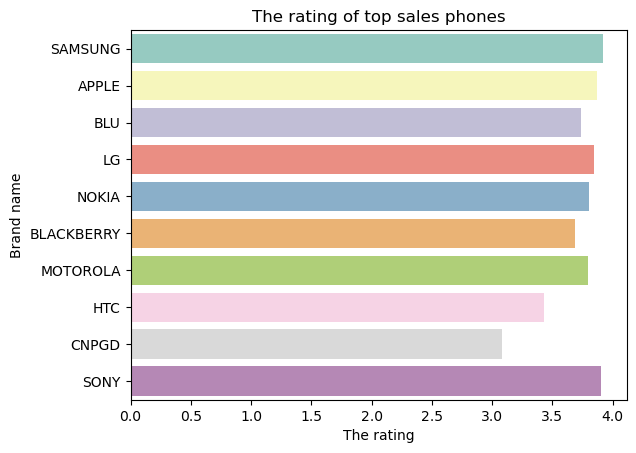

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregation for 'Stars' and 'Text' columns
aggregation = {"Stars": "mean", "Text": "count"}

# Group by 'Brand Name' and apply aggregation, then sort by 'Text' in descending order
brands = df.groupby(["Brand Name"]).agg(aggregation).sort_values(by=['Text'], ascending=False).reset_index()

# Display the 'brands' dataframe
print(brands)

# Creating a horizontal bar plot to visualize the average ratings of the top-selling phones for each brand
sns.barplot(y='Brand Name', x='Stars', data=brands.head(10), orient='h', palette='Set3')

# Adding labels and title
plt.xlabel('The rating')
plt.ylabel('Brand name')
plt.title('The rating of top sales phones')

# Display the plot
plt.show()

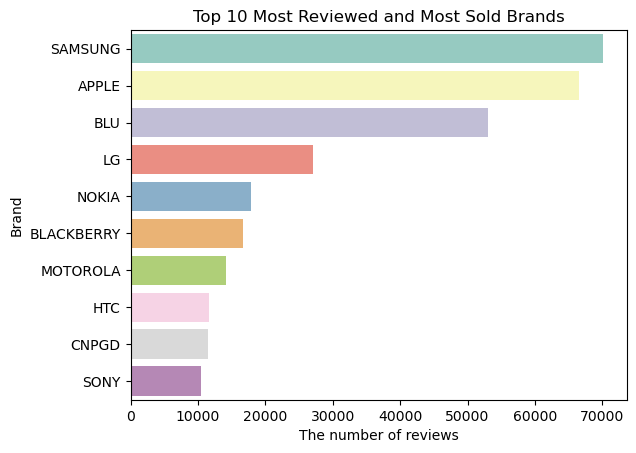

In [8]:
# Group by brand name and calculate the quantity of reviews
aggregated_data = df.groupby('Brand Name')['Text'].count().reset_index()

# Sorting the aggregated DataFrame by the number of reviews in descending order
sorted_aggregated_brand = aggregated_data.sort_values(by='Text', ascending=False)

# Selection of the first 10 most reviewed brands
top_reviewed_brand = sorted_aggregated_brand.head(10)

# Graph display
sns.barplot(y='Brand Name', x='Text', data=top_reviewed_brand, orient='h', palette='Set3')
plt.xlabel('The number of reviews')
plt.ylabel('Brand')
plt.title('Top 10 Most Reviewed and Most Sold Brands')

# Display the plot
plt.show()

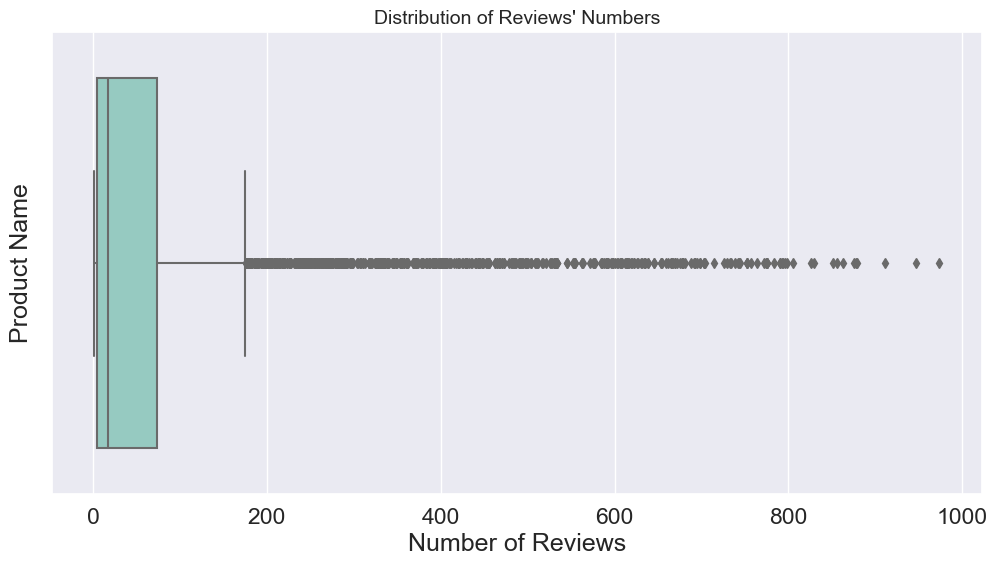

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by Product Name and calculate the quantity of reviews
aggregated_data = df.groupby('Product Name')['Text'].count().reset_index()

# Sorting the aggregated DataFrame by the number of reviews in descending order
sorted_aggregated_data_review = aggregated_data.sort_values(by='Text', ascending=False)

# Set the font scale for better readability
sns.set(font_scale=1.5)

# Create a boxplot for the distribution of reviews' numbers
plt.figure(figsize=(12, 6))
sns_plot = sns.boxplot(x="Text", data=sorted_aggregated_data_review, palette="Set3")

# Set title and labels
plt.title("Distribution of Reviews' Numbers", fontsize=14)
plt.xlabel("Number of Reviews")
plt.ylabel("Product Name")

# Show the plot
plt.show()

# Save the plot as an image
sns_plot.figure.savefig('Reviews_Distribution.png')

In [10]:
#now we are calculating the length of each review in terms of characters 
#and the number of tokens (words) and adding those as new columns in our dataframe

df['review_length'] = [len(_) for _ in df.Text]

# Get the number of tokens per review 
df['token_count'] = [len(_.split()) for _ in df.Text]

Text(0.5, 71.24999999999999, 'Length of Each Review (Number of Characters)')

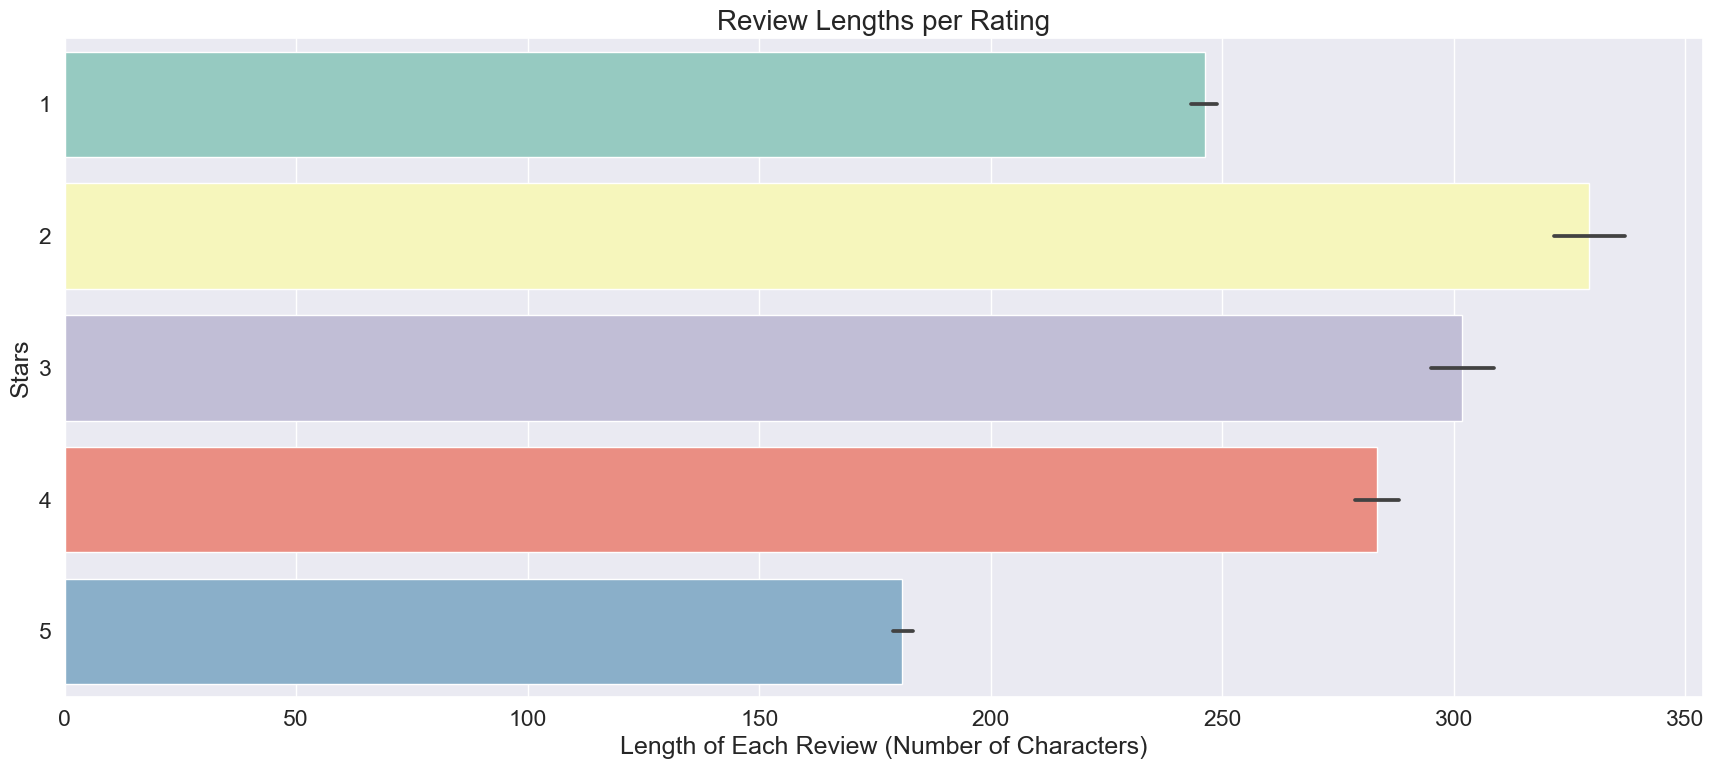

In [11]:
#plotting the relationship between review lengths and ratings using a horizontal bar plot
fig, (ax1) = plt.subplots(1, figsize=(20, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Range of Review Lengths per Rating
ax1.set_title('Review Lengths per Rating', fontsize=20)
sns.barplot(data=df, x='review_length', y='Stars',
            orient="h", palette='Set3',
            ax=ax1)

# Set x-axis label
ax1.set_xlabel('Length of Each Review (Number of Characters)')


# Deactivated Token Counts per rating - because there are the same trends

In [12]:
# Separate df into positive, neutral and negative data
df_neg = df[df["sentiment"] == "Negative"]
df_pos = df[df["sentiment"] == "Positive"]
df_neutral = df[df["sentiment"] == "Neutral"]

# Joining the reviews into a single string for each sentiment
neg_reviews = ' '.join(df_neg["Text"].values.astype(str))
pos_reviews = ' '.join(df_pos["Text"].values.astype(str))
neutral_reviews = ' '.join(df_neutral["Text"].values.astype(str))

In [45]:
# Display the first 500 characters of the positive and negative reviews
print("First 500 characters of negative reviews:\n",neg_reviews[:500])
print("\nFirst 500 characters of positive reviews:\n",pos_reviews[:500])

First 500 characters of negative reviews:
 The camera is big disappointment on many levels.The stock Android version of Acer is not smooth not its user friendly.The hardware and performance is not even as fast as the old Samsung Galaxy SIII.The bottom buttons are not illuminating, and not sensitive enough for your touch (hit them at least twice).The bottom line is: do NOT buy this phone unless you desperately need a tri-sim phone with no useful smartphone features. The description says 16GB rom, it only has 8GB rom. I am very disappointe

First 500 characters of positive reviews:
 good Fantastic product. Dual Sims are better than one sim has blurred data! Nice phone. I am waiting to be upgraded to Windows 10 Excelente Producto Item is good. The only thing is AT&T does will no longer provide 2G network service It's work well My 14 year old bought this with his babysitting money, not for a phone, but as a mini-computer with a texting app to text his friends (from wi-fi, as he has no data

# Preprocessing of Reviews

In [46]:
#Now we will replace emoji with corresponding text: example
print(df['Text'].loc[[3938]])

3938    I ordered black but 😍😍
Name: Text, dtype: object


In [47]:
import re
import emoji
import demoji

def clean_text(text):
    text = ' '.join([emoji.demojize(emo) for emo in text.split()])

    # Remove _ and - between demojised text
    pattern = r'[_,-]'
    text = re.sub(pattern, ' ', text)

    # Exchange ! to word 'exclamation'
    r = re.compile(r"!")
    text = re.sub(r, ' exclamation ', text)

    # Remove digits
    text = re.sub(r"\d+", " ", text)

    # Remove special characters
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    
    return text

# Apply the clean_text function to the 'Text' column in the DataFrame
df['Text'] = df['Text'].apply(clean_text)

# Convert the 'Text' column to lowercase
df['Text'] = df['Text'].str.lower()

# Display the first 3 rows of the DataFrame
print(df.head(3))

# Test the cleaned text for a specific row (index 3938)
print(df['Text'].loc[3938])

3938    i ordered black but smiling face with heart ey...
Name: Text, dtype: object


# filtering stopwords

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Initialize the empty word variable
stop_words = set(stopwords.words('english'))

# Adding stopwords 
stop_words.update(["theyve",'bit', 'still',"re","theyre", "theyll", "ive", "im", "ill", 
                   "could", "would", "n't","everything", 'u','one', 'two'])
# Additional domain-specific stopwords
custom_stopwords = ['phone', 'phones','cell', 'amazon', 'review', 'reviews', 'product', 'products',
                    'buy', 'producto', 'samsung', 'apple', 'android', 'mobile', 'galaxy', 'google',
                   'iphone', 'verizon', 'work', 'movistar','telefonica','lg','htc','maybe', 'blu',
                    'really', 'very', 'new', 'work', 'get', 'say']

# Adding more stopwords 
stop_words.update(custom_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulabeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
print(stop_words)

{'has', "needn't", "hasn't", 'been', 'of', 'other', 'him', 'but', 'phone', "mustn't", 'isn', 'myself', 'some', 'd', 'hadn', 'about', 'most', "you've", 'our', 'y', 'both', "wouldn't", 'be', 'now', 'hers', 'am', 'me', 'as', 'galaxy', 'hasn', 'until', 'yours', 'still', 'you', "shan't", "you'll", 'itself', 'my', 'who', 'own', 're', 't', 'very', 'theirs', 'these', "shouldn't", 'under', 'does', 'mightn', 'only', 'an', 'work', 'product', 'apple', 'telefonica', 'couldn', 'against', 'doesn', 'mustn', 'don', 'll', 'reviews', 'are', 'when', 'so', 'because', 'with', 'after', 'can', "don't", "wasn't", 'out', 'amazon', 'blu', 'this', 's', 'phones', 'such', "weren't", 'have', 'm', 'what', 'off', "mightn't", 'weren', "n't", 'in', "couldn't", 'didn', 'herself', 'htc', 'its', 'during', 'had', 'once', 'before', "should've", 'wasn', 'between', 'here', 'theyre', 'ive', 'samsung', 'android', 'the', 'aren', 'could', 'get', 'verizon', 'to', 'maybe', 'up', 'mobile', 'her', 'yourself', 'while', 'shouldn', 'whic

In [14]:
# Remove stopwords from the 'Text' column
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Display the first 3 rows of the DataFrame
df.head(3)

,Product Name,Brand Name,Price,Stars,Text,Review Votes,ReviewsNumber,sentiment,AverageRating,review_length,token_count
0,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,good,0,3,Positive,4.0,4,1
1,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,Fantastic product.,0,3,Positive,4.0,18,2
2,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,2,The camera big disappointment many levels.The ...,0,3,Negative,4.0,426,71


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339080 entries, 0 to 339079
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Product Name   339080 non-null  object 
 1   Brand Name     339080 non-null  object 
 2   Price          333981 non-null  float64
 3   Stars          339080 non-null  int64  
 4   Text           339080 non-null  object 
 5   Review Votes   339080 non-null  int64  
 6   ReviewsNumber  339080 non-null  int64  
 7   sentiment      339080 non-null  object 
 8   AverageRating  339080 non-null  float64
 9   review_length  339080 non-null  int64  
 10  token_count    339080 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 28.5+ MB


In [15]:
import csv

# Save the preprocessed data to a CSV file
df.to_csv('Supply_Chain_preprocessed.csv', sep=',', index=False, encoding='UTF8')

In [16]:
import pandas as pd

df = pd.read_csv('Supply_Chain_preprocessed.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339080 entries, 0 to 339079
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Product Name   339080 non-null  object 
 1   Brand Name     339080 non-null  object 
 2   Price          333981 non-null  float64
 3   Stars          339080 non-null  int64  
 4   Text           338958 non-null  object 
 5   Review Votes   339080 non-null  int64  
 6   ReviewsNumber  339080 non-null  int64  
 7   sentiment      339080 non-null  object 
 8   AverageRating  339080 non-null  float64
 9   review_length  339080 non-null  int64  
 10  token_count    339080 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 28.5+ MB


In [17]:
#removing rows with NaN values in the 'Text' column to handle missing data 
df.dropna(subset = ['Text'], inplace=True)

In [54]:
from nltk.tokenize import PunktSentenceTokenizer

# Instantiate a tokenizer
tokenizer = PunktSentenceTokenizer()

# Tokenize the positive, negative, and neutral reviews
tokenized_pos_reviews = tokenizer.tokenize(pos_reviews)
tokenized_neg_reviews = tokenizer.tokenize(neg_reviews)
tokenized_neutral_reviews = tokenizer.tokenize(neutral_reviews)

In [58]:
from nltk.tokenize import word_tokenize

# Tokenize the positive, negative, and neutral reviews at the word level
word_tokenized_pos_reviews = word_tokenize(pos_reviews)
word_tokenized_neg_reviews = word_tokenize(neg_reviews)
word_tokenized_neutral_reviews = word_tokenize(neutral_reviews)

In [5]:
'''
This is no longer necessary since we have tokenized our text previously


# Import the RegexpTokenizer from NLTK
from nltk.tokenize.regexp import RegexpTokenizer

# Instantiate a tokenizer with the specified regular expression pattern
tokenizer = RegexpTokenizer("[a-zA-Zé]{4,}")

# Tokenize the positive, negative, and neutral reviews using the tokenizer
#plus convert the text to lowercase before tokenization
tokens_pos = tokenizer.tokenize(pos_reviews.lower())
tokens_neg = tokenizer.tokenize(neg_reviews.lower())
tokens_neutral = tokenizer.tokenize(neutral_reviews.lower())'''

In [18]:
from nltk.tokenize import word_tokenize

tokens_pos = word_tokenize(pos_reviews, language='english')
tokens_neg = word_tokenize(neg_reviews, language='english')
tokens_neutral = word_tokenize(neutral_reviews, language='english')

#counting the total number of positive and negative review words
print(" total number of positive review words:",len(tokens_pos))
print("the number of different positive review words:",len(set(tokens_pos)))

print(" total number of negative review words:",len(tokens_neg))
print("the number of different negative review words:",len(set(tokens_neg)))

print(" total number of neutral review words:",len(tokens_neutral))
print("the number of different neutral review words:",len(set(tokens_neutral)))

 total number of positive review words: 9933846
the number of different positive review words: 102413
 total number of negative review words: 4746768
the number of different negative review words: 59393
 total number of neutral review words: 1739267
the number of different neutral review words: 32391


# Counting Words with CountVectorizer

In [62]:
#This code calculates and displays the total number of unique words in the positive reviews
#and lists the words along with their frequencies in descending order

#importing the CountVectorizer class
from  sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

#this is a common approach to convert text data into a numerical format/matirx
#that can be used with machine learning algorithms

# Initialize a vectorizer
vectorizer = CountVectorizer()

# Apply the  algorithm
vectorizer.fit_transform(tokens_pos)

# Retrieve the numbered _tokens_  
tokenized_pos = vectorizer.vocabulary_
total_words_pos = len(tokenized_pos)
print("the total number of words:", total_words_pos)

# Count the occurrences of each word 
word_counts_pos = Counter(tokenized_pos)

# Sort words by frequency in descending order
sorted_words_pos = sorted(word_counts_pos.items(), key=lambda x: x[1], reverse=False)

'''We leave this out as it is too much information and not relevant at this point.

# Display the sorted words and their frequencies
for word, count in sorted_words_pos:
    print(f"{word}: {count}")'''

the total number of words: 50037


'We leave this out as it is too much information and not relevant at this point.\n\n# Display the sorted words and their frequencies\nfor word, count in sorted_words_pos:\n    print(f"{word}: {count}")'

In [63]:
# Initialize a vectorizer
vectorizer = CountVectorizer()

# Apply the  algorithm
vectorizer.fit_transform(tokens_neg)

# Retrieve the numbered _tokens_  
tokenized_neg = vectorizer.vocabulary_

# Display the total number of words
total_words_neg = len(tokenized_neg)
print("the total number of negative review words:", total_words_neg)

the total number of negative review words: 32729


In [64]:
# Count the occurrences of each word
word_counts_neg = Counter(tokenized_neg)

# Sort words by frequency in descending order
sorted_words_neg = word_counts_neg.most_common()

'''

We leave this out as it is too much information and not relevant at this point.

# Display the sorted words and their frequencies
for word, count in sorted_words_neg:
    print(f"{word}: {count}")

'''

'\n\nWe leave this out as it is too much information and not relevant at this point.\n\n# Display the sorted words and their frequencies\nfor word, count in sorted_words_neg:\n    print(f"{word}: {count}")\n\n'

In [65]:
# Initialize a vectorizer
vectorizer = CountVectorizer()

# Apply the  algorithm
vectorizer.fit_transform(tokens_neutral)

# Retrieve the numbered _tokens_  
tokenized_neutral = vectorizer.vocabulary_

# Display the total number of words
total_words_neutral = len(tokenized_neutral)
print("the total number of neutral review words:", total_words_neutral)

the total number of neutral review words: 19104


In [66]:
# Count the occurrences of each word
#word_counts_neutral = Counter(tokenized_neutral)

# Sort words by frequency in descending order
#sorted_words_neutral = word_counts_neutral.most_common()

# Display the sorted words and their frequencies
#for word, count in sorted_words_neutral:
    #print(f"{word}: {count}")

In [69]:
!pip install wordcloud

In [67]:
#importing Images of a heart and a thumbs down for the wordcloud

from PIL import Image
import numpy as np

mask_pos = np.array(Image.open("heart.jpg"))
mask_neg = np.array(Image.open("dislike.jpg"))
mask_apple = np.array(Image.open("apple.jpg"))
mask_samsung = np.array(Image.open("samsung.jpg"))
mask_neutral = np.array(Image.open("neutral.jpg"))

# Wordcloud positive Comments

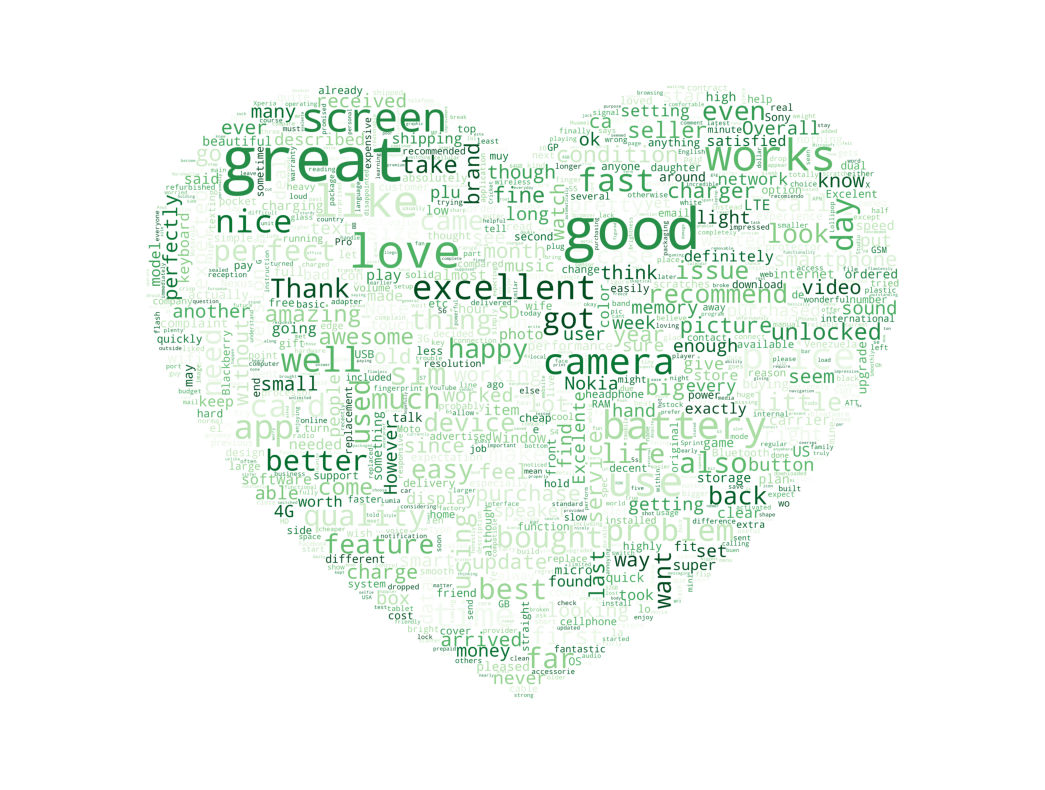

In [68]:
#Importing the necessary packages
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Joining the positive review tokens into a single string
text_pos = ' '.join(tokens_pos)

#Instanciating the word cloud for positive reviews template
wc_pos = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='Greens',
                   stopwords=stop_words,
                   max_font_size=400,
                   collocations = False,
                   random_state =42, mask=mask_pos)

# Generate the word cloud for positive reviews
wc_pos.generate(text_pos)

# Generate and display the word cloud for positive reviews
plt.figure(figsize= (16,10)) # Initialization of a figure
plt.imshow(wc_pos) # Display
plt.xticks([])
plt.yticks([])
plt.show();

#plot_word_cloud(text_pos, "heart.jpg")

# Wordcloud negative comments

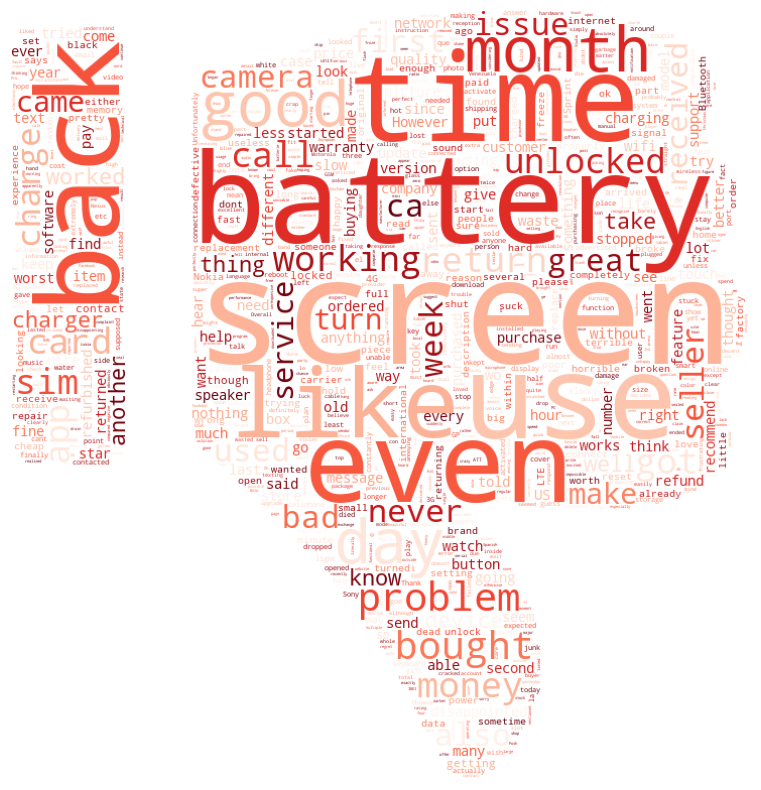

In [69]:
# Joining the negative review tokens into a single string
text_neg = ' '.join(tokens_neg)

#Instanciating the word cloud for negative reviews template
wc_neg = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='Reds', 
                   stopwords=stop_words,
                   max_font_size=400,
                   collocations = False,
                   random_state =42,
                   mask=mask_neg)

# Generate the word cloud for negative reviews
wc_neg.generate(text_neg)

# Generate and display the word cloud for negative reviews
plt.figure(figsize= (16,10)) # Initialization of a figure
plt.imshow(wc_neg) # Display
plt.xticks([])
plt.yticks([])
plt.show();

# Wordcloud Neutral

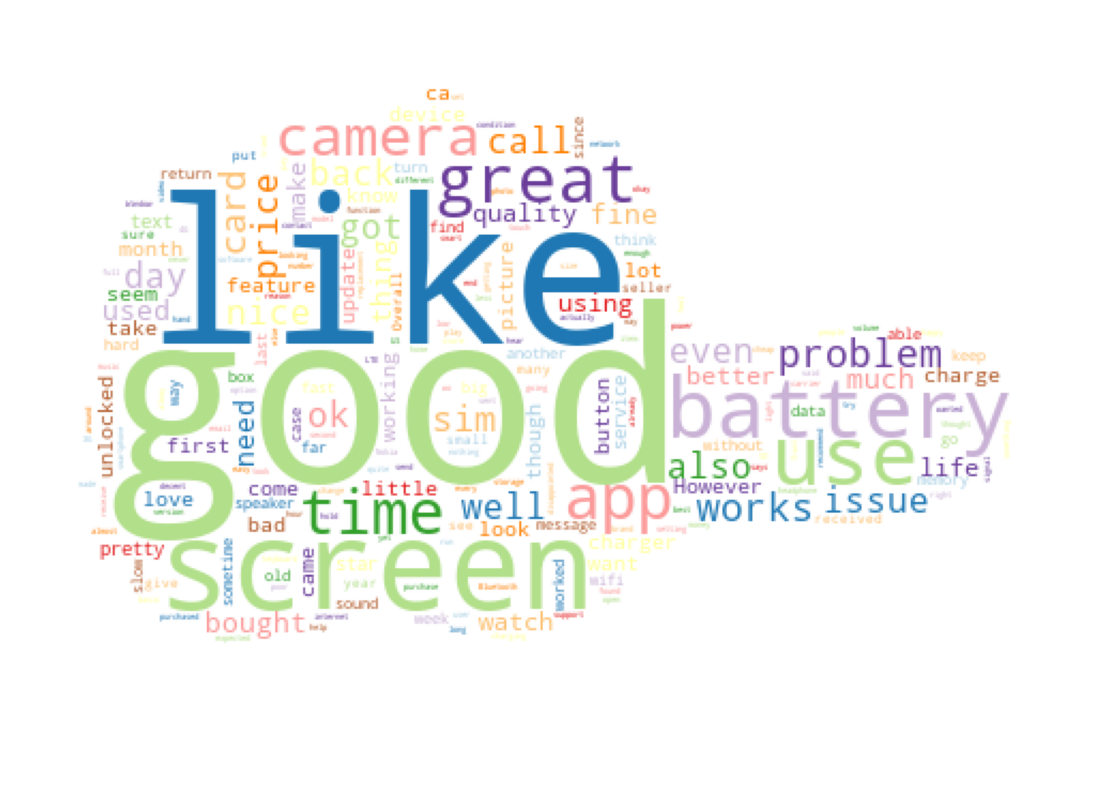

In [70]:
# Joining the neutral review tokens into a single string
text_neutral = ' '.join(tokens_neutral)

#Instanciating the word cloud for neutral reviews template
wc_neutral = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='Paired', 
                   stopwords=stop_words,
                   max_font_size=400,
                   collocations = False,
                   random_state =42,
                   mask=mask_neutral)

# Generate the word cloud for neutral reviews
wc_neutral.generate(text_neutral)

# Generate and display the word cloud for neutral reviews
plt.figure(figsize= (16,10)) # Initialization of a figure
plt.imshow(wc_neutral) # Display
plt.xticks([])
plt.yticks([])
plt.show();

In [71]:
#Dataframes separating samsung and apple reviews by sentiments
bad_rating_samsung=df[(df['sentiment'] =='Negative') & (df['Brand Name']== 'SAMSUNG')]
good_rating_samsung= df[(df['sentiment'] =='Positive')&(df['Brand Name']== 'SAMSUNG')]
middle_rating_samsung=df[(df['sentiment'] =='Neutral')&(df['Brand Name']== 'SAMSUNG')]
 
bad_rating_apple=df[(df['sentiment'] =='Negative') & (df['Brand Name']== 'APPLE')]
good_rating_apple=df[(df['sentiment'] =='Positive')&(df['Brand Name']== 'APPLE')]
middle_rating_apple=df[(df['sentiment'] =='Neutral')&(df['Brand Name']== 'APPLE')] 

bad_rating_blu=df[(df['sentiment'] =='Negative') & (df['Brand Name']== 'BLU')]
good_rating_blu=df[(df['sentiment'] =='Positive')&(df['Brand Name']== 'BLU')]
middle_rating_blu=df[(df['sentiment'] =='Neutral')&(df['Brand Name']== 'BLU')]

# Wordcloud Samsung

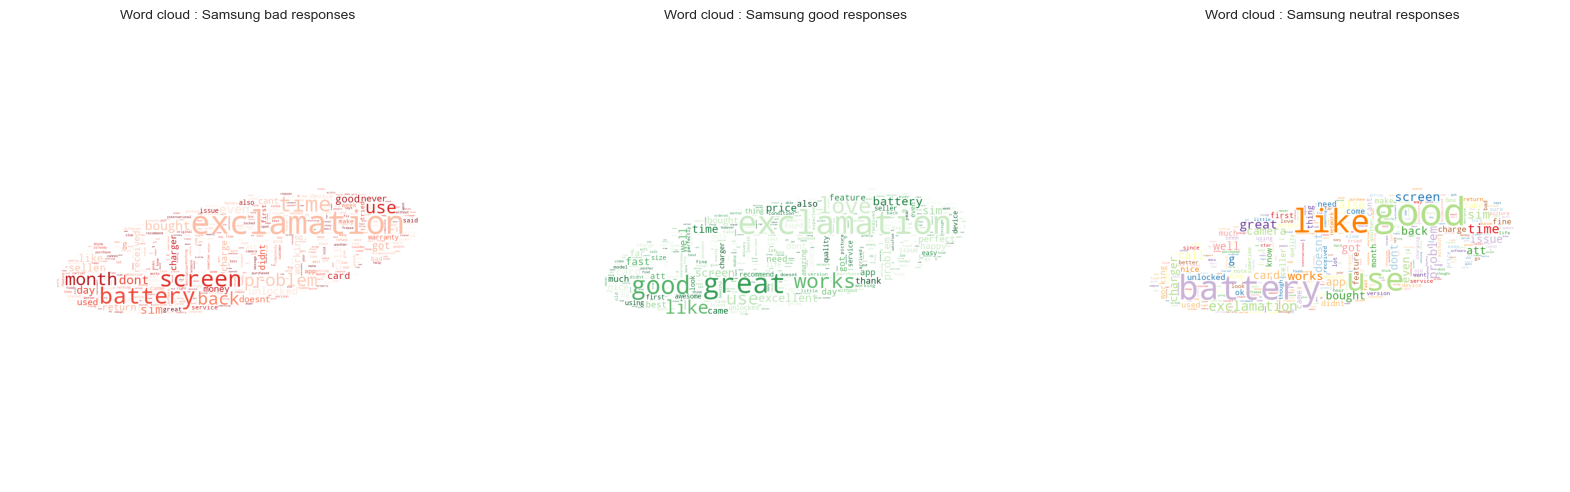

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,20))

# Joining the negative review tokens into a single string
text_samsung_bad = ' '.join(bad_rating_samsung.Text)

#Instanciating the word cloud for negative reviews template
wc_samsung_bad = WordCloud(background_color="white",
                    max_words=1000,
                    colormap='Reds',
                    stopwords=stop_words,
                    max_font_size=400,
                    collocations = False,
                    random_state =42,
                    mask=mask_samsung)

# Generate the word cloud for negative reviews
wc_samsung_bad.generate(text_samsung_bad)

# Generate and display the word cloud for negative reviews
# Initialization of a figure
plt.subplot(131)
plt.title('Word cloud : Samsung bad responses', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(wc_samsung_bad) # Display



text_samsung_good = ' '.join(good_rating_samsung.Text)

#Instanciating the word cloud for positive reviews template
wc_samsung_good= WordCloud(background_color="white",
                    max_words=1000,
                    colormap='Greens', 
                    stopwords=stop_words,
                    max_font_size=400,
                    collocations = False,
                    random_state =42,
                    mask=mask_samsung)

# Generate the word cloud for positive reviews
wc_samsung_good.generate(text_samsung_good)

# Generate and display the word cloud for positive reviews
plt.subplot(132)
plt.title('Word cloud : Samsung good responses', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(wc_samsung_good); # Display


text_samsung_neutral = ' '.join(middle_rating_samsung.Text)

#Instanciating the word cloud for neutral reviews template
wc_samsung_neutral = WordCloud(background_color="white",
                   max_words=1000,
                   stopwords=stop_words,
                   colormap='Paired',           
                   max_font_size=400,
                   collocations = False,
                   random_state =42,
                   mask=mask_samsung)

# Generate the word cloud for neutral reviews
wc_samsung_neutral.generate(text_samsung_neutral)

# Generate and display the word cloud for neutral reviews
plt.subplot(133)
plt.title('Word cloud : Samsung neutral responses', fontsize=10)
plt.imshow(wc_samsung_neutral); # Display
plt.xticks([])
plt.yticks([])
plt.show();

# Wordcloud Apple

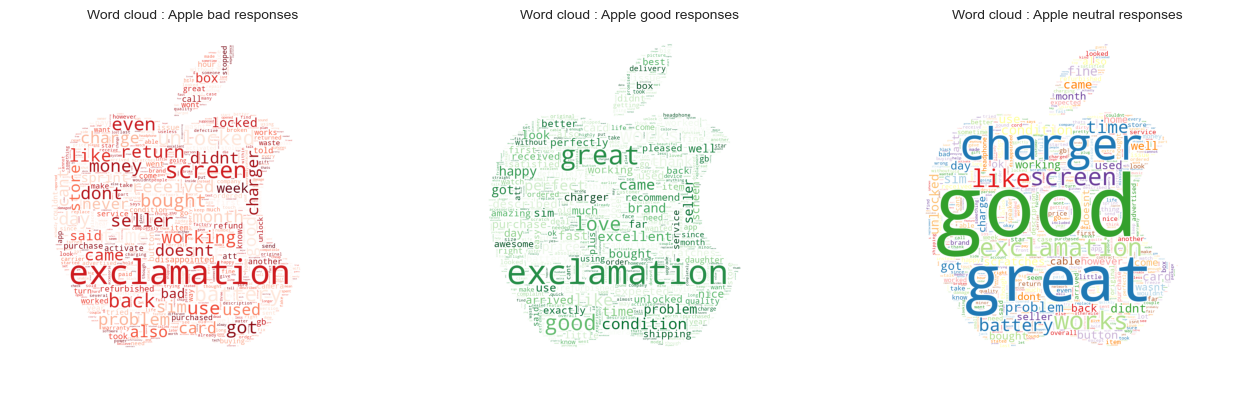

In [77]:
ig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
 
text_apple_bad = ' '.join(bad_rating_apple.Text)

#Instanciating the word cloud for negative reviews template
wc_apple_bad = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='Reds', 
                   stopwords=stop_words,
                   max_font_size=400,
                   collocations = False,
                   random_state =42, mask=mask_apple)

# Generate the word cloud for negative reviews
wc_apple_bad.generate(text_apple_bad)

# Generate and display the word cloud for negative reviews
plt.subplot(131)
plt.title('Word cloud : Apple bad responses', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(wc_apple_bad); # Display


text_apple_good = ' '.join(good_rating_apple.Text)

#Instanciating the word cloud for positive reviews template
wc_apple_good = WordCloud(background_color="white",
                   max_words=1000,
                   stopwords=stop_words,
                   colormap='Greens',           
                   max_font_size=400,
                   collocations = False,
                   random_state =42,
                   mask=mask_apple)

# Generate the word cloud for positive reviews
wc_apple_good.generate(text_apple_good)

# Generate and display the word cloud for positive reviews
plt.subplot(132)
plt.title('Word cloud : Apple good responses', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(wc_apple_good); # Display


text_apple_neu = ' '.join(middle_rating_apple.Text)

#Instanciating the word cloud for neutral reviews template
wc_apple_neu = WordCloud(background_color="white",
                   max_words=1000,
                   stopwords=stop_words,
                   colormap='Paired',          
                   max_font_size=400,
                   collocations = False,
                   random_state =42, mask=mask_apple)

# Generate the word cloud for positive reviews
wc_apple_neu.generate(text_apple_neu)

# Generate and display the word cloud for positive reviews
plt.subplot(133)
plt.title('Word cloud : Apple neutral responses', fontsize=10)
plt.imshow(wc_apple_neu) # Display
plt.xticks([])
plt.yticks([])
plt.show();

In [78]:
df.head()

,Product Name,Brand Name,Price,Stars,Text,Review Votes,ReviewsNumber,sentiment,AverageRating,review_length,token_count
0,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,good,0,3,Positive,4.0,4,1
1,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,5,fantastic product,0,3,Positive,4.0,18,2
2,ACER LIQUID E700 TRIO 16GB TITAN BLACK TRIPLE ...,ACER,139.95,2,the camera is big disappointment on many level...,0,3,Negative,4.0,426,71
3,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,ACER,129.99,1,the description says gb rom it only has gb ...,0,2,Negative,1.5,119,20
4,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,ACER,129.99,2,i had high hopes for this acer phone based the...,0,2,Negative,1.5,800,145


# First Try: Decision Tree

In [19]:
#splitting into training and testing set
from sklearn.model_selection import train_test_split
import numpy as np

X, y = np.asarray(df.Text), np.asarray(df.sentiment)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)


#using Countvectorizer to transform
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)

X_test_vectorized = vectorizer.transform(X_test)

In [94]:
#we try with a Decision Tree
from sklearn.tree import DecisionTreeClassifier

#instanciation
decision_tree = DecisionTreeClassifier()

#training the model
decision_tree.fit(X_train_vectorized, y_train)

#prediction
y_pred_decision_tree = decision_tree.predict(X_test_vectorized)


#evaluation of the two models
from sklearn.metrics import classification_report

#Classification report for Decision Tree
print("Classiciation report of Decision Tree:\n", classification_report(y_pred_decision_tree, y_test))

#Confusion Matrix for DecisionTree
confusion_matrix = pd.crosstab(y_test, y_pred_decision_tree, rownames =["Real sentiment"], colnames=["Predicted sentiment"])
print("Confusion matrix of decision tree:\n")
confusion_matrix

#the neutral column is hard to predict and is doing really bad!

Classiciation report of Decision Tree:
               precision    recall  f1-score   support

    Negative       0.86      0.86      0.86     20797
     Neutral       0.61      0.70      0.65      5976
    Positive       0.95      0.93      0.94     57764

    accuracy                           0.90     84537
   macro avg       0.81      0.83      0.82     84537
weighted avg       0.90      0.90      0.90     84537

Confusion matrix of decision tree:



Predicted class,Negative,Neutral,Positive
Actual class,,,
Negative,17902,782,2150
Neutral,1026,4186,1628
Positive,1869,1008,53986


In [93]:
from sklearn.metrics import accuracy_score

y_train_decision_tree=decision_tree.predict(X_train_vectorized)
accuracy_train = accuracy_score(y_train, y_train_decision_tree)
accuracy_train

#see the differency between accuracy scores of trained and test models

0.9897321851045708

# Gradient Boosting

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#instanciation
gradient_boosting = GradientBoostingClassifier()

#training the model
gradient_boosting.fit(X_train_vectorized, y_train)

#prediction
y_pred_gradient_boosting = gradient_boosting.predict(X_test_vectorized)

#Classification report for GradientBoosting
print("Classiciation report of Gradient boosting:\n", classification_report(y_pred_gradient_boosting, y_test))

#Confusion Matrix for GradientBoosting
confusion_matrix = pd.crosstab(y_test, y_pred_gradient_boosting, rownames =["Real sentiment"], colnames=["Predicted sentiment"])
print("Confusion matrix of gradient boosting:\n")
confusion_matrix

Classiciation report of Gradient boosting:
               precision    recall  f1-score   support

    Negative       0.47      0.82      0.60     11944
     Neutral       0.03      0.65      0.06       314
    Positive       0.98      0.77      0.86     72279

    accuracy                           0.78     84537
   macro avg       0.49      0.75      0.51     84537
weighted avg       0.91      0.78      0.82     84537

Confusion matrix of gradient boosting:



Predicted sentiment,Negative,Neutral,Positive
Real Sentiment,,,
Negative,9827,58,10949
Neutral,1093,203,5544
Positive,1024,53,55786


In [96]:
y_train_gradient_boosting=gradient_boosting.predict(X_train_vectorized)
accuracy_train = accuracy_score(y_train, y_train_gradient_boosting)
accuracy_train
#most of neutral sentiments recognised as positive, have of negative recognised as positive


0.7808586479921769

# Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#instantiation
lr = LogisticRegression(max_iter=1000)

#fitting the training set
lr.fit(X_train_vectorized, y_train)
y_pred = lr.predict(X_test_vectorized)

#Evaluation with confusion matrix
cm_lr = pd.crosstab(y_test, y_pred, rownames=['Real sentiment'], colnames=['Predicted sentiment'])
display(cm_lr)

#Evaluation with classification report
print("Classificationreport of the Logistic Regression:\n",classification_report(y_test, y_pred))

predicted Class,Negative,Neutral,Positive
Real se´,,,
Negative,17599,468,2767
Neutral,1758,2296,2786
Positive,1439,631,54793


Classificationreport of the Logistic Regression:
               precision    recall  f1-score   support

    Negative       0.85      0.84      0.85     20834
     Neutral       0.68      0.34      0.45      6840
    Positive       0.91      0.96      0.93     56863

    accuracy                           0.88     84537
   macro avg       0.81      0.71      0.74     84537
weighted avg       0.87      0.88      0.87     84537



In [98]:
y_train_log_reg=lr.predict(X_train_vectorized)
accuracy_train = accuracy_score(y_train, y_train_log_reg)
accuracy_train

0.9155073972429891

# Support Vector Machine

In [ ]:
#it was not possible with my computer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Instantiate SVM
svc = SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_vectorized, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for prediction
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test_vectorized)

# Evaluation with confusion matrix
cm_svc = pd.crosstab(y_test, y_pred, rownames=['Real sentiment'], colnames=['Predicted sentiment'])
display(cm_svc)

# Evaluation with classification report
print("Classification report of the SVM:\n", classification_report(y_test, y_pred))

In [ ]:
y_train_svc=best_svc.predict(X_train_vectorized)
accuracy_train = accuracy_score(y_train, y_train_svc)
accuracy_train

# Random Forest 

In [9]:
#from sklearn.linear_model import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import ensemble

#instantiation
rf = ensemble.RandomForestClassifier(n_jobs=-1)

#fitting the training set
rf.fit(X_train_vectorized, y_train)
y_pred = rf.predict(X_test_vectorized)

#Evaluation with confusion matrix
cm_rf = pd.crosstab(y_test, y_pred, rownames=['Real sentiment'], colnames=['Predicted sentiment'])
display(cm_rf)

#Evaluation with classification report
print("Classificationreport of the Random Forest:\n", classification_report(y_test, y_pred))

Predicted sentiment,Negative,Neutral,Positive
Real sentiment,,,
Negative,18967,91,1777
Neutral,1029,3898,1974
Positive,944,93,55764


Classificationreport of the Random Forest:
               precision    recall  f1-score   support

    Negative       0.91      0.91      0.91     20835
     Neutral       0.95      0.56      0.71      6901
    Positive       0.94      0.98      0.96     56801

    accuracy                           0.93     84537
   macro avg       0.93      0.82      0.86     84537
weighted avg       0.93      0.93      0.93     84537



In [10]:
y_train_rf=rf.predict(X_train_vectorized)
accuracy_train = accuracy_score(y_train, y_train_rf)
accuracy_train

0.9898859657424056

# Random Oversampling and SMOTE for Random Forest

Sample Classes oversampled : {'Positive': 171405, 'Negative': 171405, 'Neutral': 171405}
Classification report of Random Forest with Resampling:
                    pre       rec       spe        f1       geo       iba       sup

   Negative       0.92      0.90      0.97      0.91      0.94      0.87     21172
    Neutral       0.61      0.83      0.97      0.70      0.90      0.79      4872
   Positive       0.97      0.95      0.93      0.96      0.94      0.88     58696

avg / total       0.94      0.93      0.94      0.93      0.94      0.87     84740

Confusion matrix of Random Forest with Resampling:
 Predicted class  Negative  Neutral  Positive
Actual class                                
Negative            19090      154      1512
Neutral               964     4058      1679
Positive             1118      660     55505


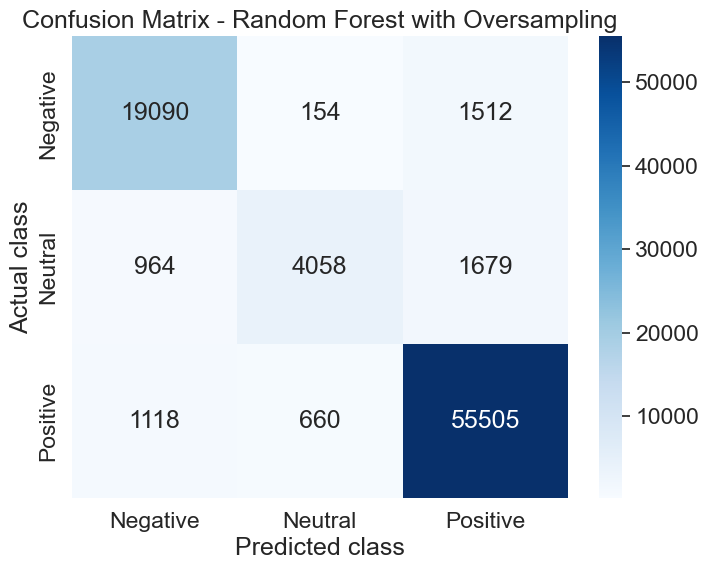

ValueError: could not convert string to float: 'Bought cellphone mom almost 3 years ago worked great siblings getting newest generations since then.My mom dropped, give heavy use, cellphone like new.The good:-Durable-Great price-Love use slightly modified Android VanillaThe Bad:-Small memory-No expandable port'

In [21]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
import joblib
import pickle

# Define the model
rf = RandomForestClassifier(n_jobs=-1)

# Define the sampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply over- and under sampling separately
X_ro, y_ro = ros.fit_resample(X_train_vectorized, y_train)
print('Sample Classes oversampled :', dict(pd.Series(y_ro).value_counts()))

# Fit the model with resampled data
rf.fit(X_ro, y_ro)

# Prediction
y_pred_rf_resampled = rf.predict(X_test_vectorized)

# Evaluation of the oversampled model
print("Classification report of Random Forest with Resampling:\n",
      classification_report_imbalanced(y_pred_rf_resampled, y_test))

# Confusion Matrix for Random Forest with Oversampling
confusion_matrix_rf_oversampled = pd.crosstab(y_test, y_pred_rf_resampled,
                                                       rownames=["Actual class"], colnames=["Predicted class"])
print("Confusion matrix of Random Forest with Resampling:\n", 
      confusion_matrix_rf_oversampled)

import seaborn as sns

# Plot the heatmap for Random Forest with Oversampling
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_rf_oversampled, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest with Oversampling")
plt.show()

# Save the trained model using Joblib
model_filename = "Random_Forest_oversampled_model.joblib"
joblib.dump(rf, model_filename)
    

# Calculate and save accuracy
accuracy = rf.score(X_test_vectorized, y_test)
accuracy_filename = "Random_Forest_oversampled_accuracy.pkl"
with open(accuracy_filename, 'wb') as accuracy_file:
     pickle.dump(accuracy, accuracy_file)

# Calculate and save confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_rf_resampled)
confusion_matrix_filename = "Random_Forest_oversampled_confusion_matrix.pkl"
with open(confusion_matrix_filename, 'wb') as confusion_matrix_file:
    pickle.dump(confusion_matrix_result, confusion_matrix_file)

Sample Classes SMOTE: {'Positive': 171405, 'Negative': 171405, 'Neutral': 171405}
Classification report of Random Forest with SMOTE:
                    pre       rec       spe        f1       geo       iba       sup

   Negative       0.91      0.90      0.97      0.90      0.93      0.87     21015
    Neutral       0.66      0.49      0.97      0.56      0.69      0.45      8992
   Positive       0.91      0.95      0.83      0.93      0.89      0.80     54733

avg / total       0.88      0.89      0.88      0.88      0.88      0.78     84740

Confusion matrix of Rondom Forest with SMOTE:
 Predicted sentiment  Negative  Neutral  Positive
Real sentiment                                  
Negative                18885      579      1292
Neutral                   913     4415      1373
Positive                 1217     3998     52068


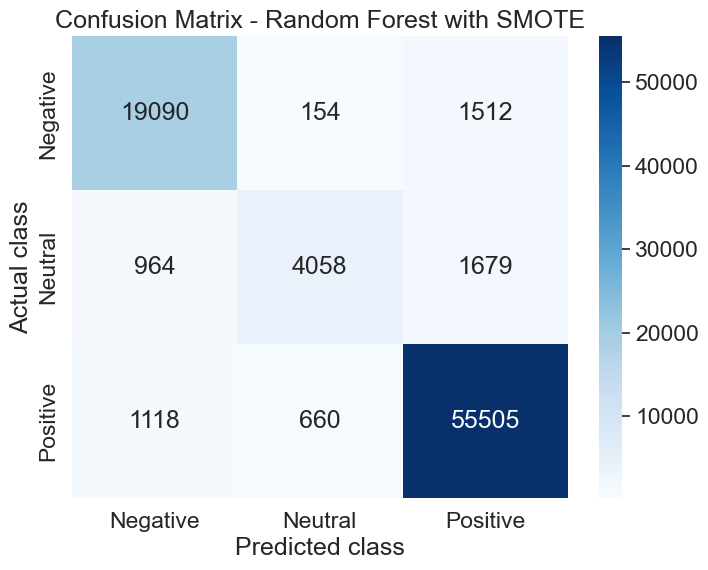

ValueError: could not convert string to float: 'Bought cellphone mom almost 3 years ago worked great siblings getting newest generations since then.My mom dropped, give heavy use, cellphone like new.The good:-Durable-Great price-Love use slightly modified Android VanillaThe Bad:-Small memory-No expandable port'

In [23]:
import joblib
import pickle

smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE separately
X_sm, y_sm = smote.fit_resample(X_train_vectorized, y_train)
print('Sample Classes SMOTE:', dict(pd.Series(y_sm).value_counts()))

# Fit the models with SMOTE data
rf.fit(X_sm, y_sm)

# Predictions
y_pred_rf_smote = rf.predict(X_test_vectorized)


# Evaluation of the SMOTE models
print("Classification report of Random Forest with SMOTE:\n",
      classification_report_imbalanced(y_pred_rf_smote, y_test))

# Confusion Matrix for DecisionTree with SMOTE
print("Confusion matrix of Rondom Forest with SMOTE:\n", pd.crosstab(y_test, y_pred_rf_smote,
                                                   rownames=["Real sentiment"], colnames=["Predicted sentiment"]))

import seaborn as sns

# Plot the heatmap for Random Forest with Smote
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_rf_oversampled, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.show()

model_filename = "Random_Forest_smote_model.joblib"
joblib.dump(rf, model_filename)
    

# Calculate and save accuracy
accuracy = rf.score(X_test, y_test)
accuracy_filename = "Random_Forest_smote_accuracy.pkl"
with open(accuracy_filename, 'wb') as accuracy_file:
     pickle.dump(accuracy, accuracy_file)

# Calculate and save confusion matrix
confusion_matrix_result = confusion_matrix(y_test, rf.predict(X_test_vectorized))
confusion_matrix_filename = "Random_Forest_smote_confusion_matrix.pkl"
with open(confusion_matrix_filename, 'wb') as confusion_matrix_file:
    pickle.dump(confusion_matrix_result, confusion_matrix_file)

# Random Oversampling and SMOTE for Decision Tree and Gradient Boosting

Sample Classes oversampled : {'Positive': 171794, 'Negative': 171794, 'Neutral': 171794}
Classification report of Decision Tree with Resampling:
                    pre       rec       spe        f1       geo       iba       sup

   Negative       0.87      0.86      0.96      0.86      0.91      0.81     21039
    Neutral       0.67      0.60      0.97      0.63      0.76      0.56      7634
   Positive       0.93      0.95      0.86      0.94      0.90      0.82     56177

avg / total       0.89      0.89      0.89      0.89      0.89      0.79     84850

Classification report of Gradient Boosting with Resampling:
                    pre       rec       spe        f1       geo       iba       sup

   Negative       0.72      0.72      0.91      0.72      0.81      0.64     20832
    Neutral       0.52      0.23      0.95      0.32      0.47      0.20     15552
   Positive       0.78      0.92      0.66      0.85      0.78      0.62     48466

avg / total       0.72      0.75      0.7

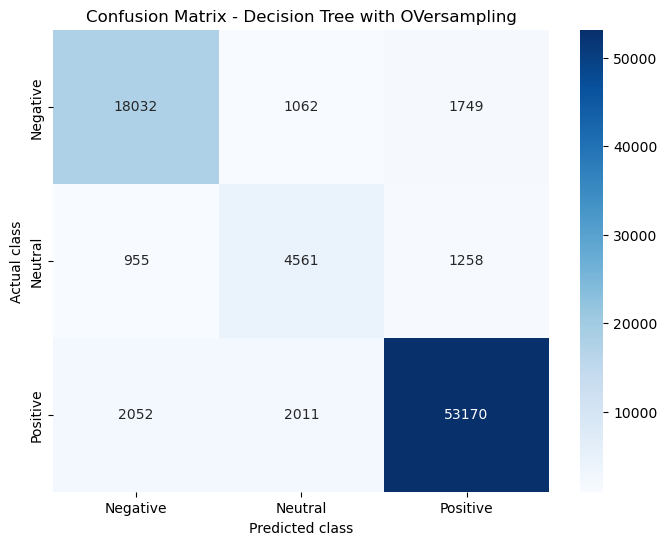

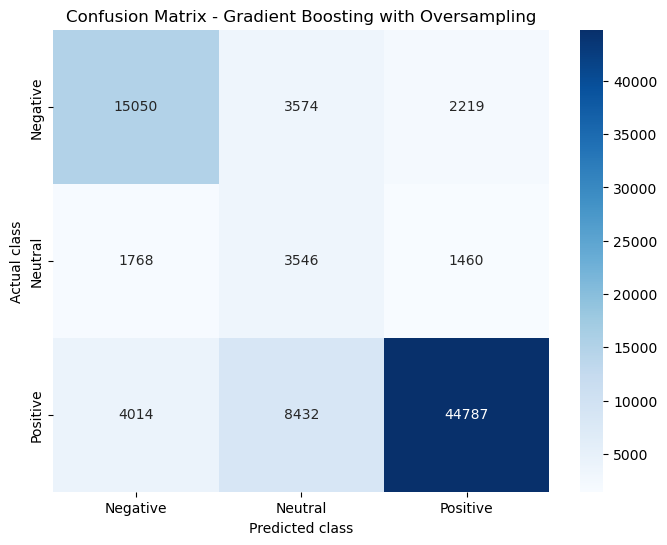

In [43]:
#I could not calculated this so fast
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# Define the models
decision_tree = DecisionTreeClassifier()
gradient_boosting = GradientBoostingClassifier()

# Define the samplers
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply over- and under sampling separately
X_ro, y_ro = ros.fit_resample(X_train_vectorized, y_train)
print('Sample Classes oversampled :', dict(pd.Series(y_ro).value_counts()))

# Fit the models with resampled data
decision_tree.fit(X_ro, y_ro)
gradient_boosting.fit(X_ro, y_ro)

# Predictions
y_pred_decision_tree_resampled = decision_tree.predict(X_test_vectorized)
y_pred_gradient_boosting_resampled = gradient_boosting.predict(X_test_vectorized)

# Evaluation of the oversampled models
print("Classification report of Decision Tree with Resampling:\n",
      classification_report_imbalanced(y_pred_decision_tree_resampled, y_test))
print("Classification report of Gradient Boosting with Resampling:\n",
      classification_report_imbalanced(y_pred_gradient_boosting_resampled, y_test))

# Confusion Matrix for DecisionTree with Oversampling
confusion_matrix_decision_tree_oversampled = pd.crosstab(y_test, y_pred_decision_tree_resampled,
                                                       rownames=["Actual class"], colnames=["Predicted class"])
print("Confusion matrix of Decision Tree with Resampling:\n", 
      confusion_matrix_decision_tree_oversampled)

# Confusion Matrix for GradientBoosting with Oversampling
confusion_matrix_gradient_boosting_oversampled = pd.crosstab(y_test, y_pred_gradient_boosting_resampled,
                                                           rownames=["Actual class"], colnames=["Predicted class"])
print("Confusion matrix of Gradient Boosting with Resampling:\n", 
      confusion_matrix_gradient_boosting_oversampled)

import seaborn as sns

# Plot the heatmap for DecisionTree with Oversampling
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_decision_tree_oversampled, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree with Oversampling")
plt.show()

# Plot the heatmap for GradientBoosting with Oversampling
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_gradient_boosting_oversampled, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Gradient Boosting with Oversampling")
plt.show()

In [45]:
# Apply SMOTE separately
X_sm, y_sm = smote.fit_resample(X_train_vectorized, y_train)
print('Sample Classes SMOTE:', dict(pd.Series(y_sm).value_counts()))

# Fit the models with SMOTE data
decision_tree.fit(X_sm, y_sm)
gradient_boosting.fit(X_sm, y_sm)

# Predictions
y_pred_decision_tree_smote = decision_tree.predict(X_test_vectorized)
y_pred_gradient_boosting_smote = gradient_boosting.predict(X_test_vectorized)

# Evaluation of the SMOTE models
print("Classification report of Decision Tree with SMOTE:\n",
      classification_report_imbalanced(y_pred_decision_tree_smote, y_test))
print("Classification report of Gradient Boosting with SMOTE:\n",
      classification_report_imbalanced(y_pred_gradient_boosting_smote, y_test))

# Confusion Matrix for DecisionTree with SMOTE
print("Confusion matrix of Decision Tree with SMOTE:\n", pd.crosstab(y_test, y_pred_decision_tree_smote,
                                                   rownames=["Real sentiment"], colnames=["Predicted sentiment"]))

# Confusion Matrix for GradientBoosting with SMOTE
print("Confusion matrix of Gradient Boosting with SMOTE:\n",pd.crosstab(y_test, y_pred_gradient_boosting_smote,
                                                       rownames=["Real sentiment"], colnames=["Predicted sentiment"]))

Sample Classes SMOTE: {'Positive': 171794, 'Negative': 171794, 'Neutral': 171794}
Classification report of Decision Tree with SMOTE:
                    pre       rec       spe        f1       geo       iba       sup

   Negative       0.85      0.85      0.95      0.85      0.90      0.80     20948
    Neutral       0.70      0.47      0.97      0.56      0.68      0.44     10034
   Positive       0.90      0.95      0.81      0.93      0.88      0.79     53868

avg / total       0.86      0.87      0.87      0.86      0.86      0.75     84850

Classification report of Gradient Boosting with SMOTE:
                    pre       rec       spe        f1       geo       iba       sup

   Negative       0.76      0.69      0.92      0.72      0.80      0.62     22770
    Neutral       0.50      0.19      0.95      0.27      0.42      0.17     18074
   Positive       0.72      0.94      0.61      0.82      0.76      0.59     44006

avg / total       0.69      0.71      0.77      0.68      

# RandomUndersampling and Cluster Centroids for Decision Tree and Gradient Boosting

# XGBoost

In [4]:
#replace the values of df.sentiment to integers
#this was the requirement of XGBoost and CNN

df.sentiment = df.sentiment.replace(['Positive','Negative','Neutral'],[2,0,1])

In [13]:
#XGBoost with Count Vectorizer
vectorizer = CountVectorizer(max_features=2000)
data_features = vectorizer.fit_transform(df['Text'])
data_features = data_features.toarray()

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, df.sentiment, test_size=0.2, random_state=42)

In [15]:
import xgboost as xgb
model = xgb.XGBClassifier(max_depth=10, n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print("Confusion matrix of XGBoost:\n")
pd.crosstab(y_test, predictions,rownames=["Real sentiment"], colnames=["Predicted sentiment"])

              precision    recall  f1-score   support

           0       0.82      0.70      0.76     16500
           1       0.82      0.13      0.22      5331
           2       0.85      0.97      0.90     45798

    accuracy                           0.84     67629
   macro avg       0.83      0.60      0.63     67629
weighted avg       0.84      0.84      0.82     67629

Confusion matrix of XGBoost:



Predicted sentiment,0,1,2
Real sentiment,,,
0,11620,79,4801
1,1327,693,3311
2,1216,76,44506


In [17]:
y_train_xgb=model.predict(X_train)
accuracy_train=accuracy_score(y_train,y_train_xgb)
accuracy_train

0.8505116148397877

In [5]:
#We try with TF-IDF vectorizer:random forests
#I performed here some manipulations fot get feature importances from TF-IDF matrix (name of columns -words)
#in general all this was not essential
#and possible to do absolutely the same way as CountVectorizer)

from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.Text, df.sentiment, test_size=0.2, random_state=1000)

In [7]:
tfidf_vect = TfidfVectorizer(max_features=2000)
tfidf_vect_fit=tfidf_vect.fit(X_train)
X_train=vectorize(X_train,tfidf_vect_fit)
X_test=vectorize(X_test,tfidf_vect_fit)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

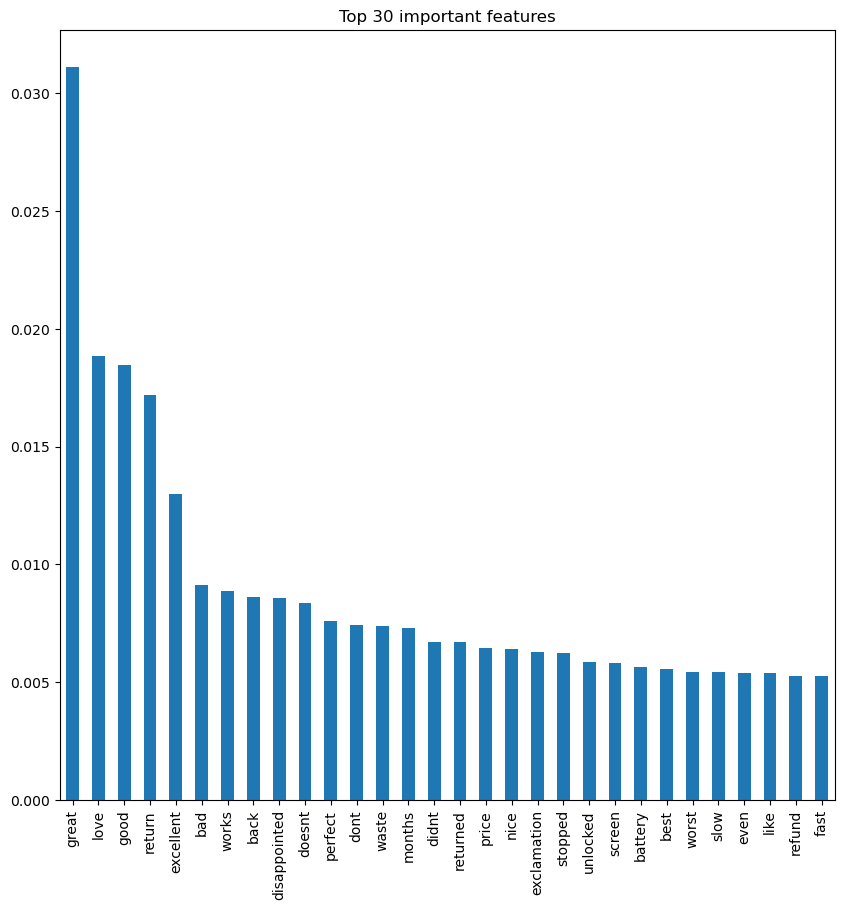

In [22]:
import matplotlib.pyplot as plt


feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='bar',figsize=(10,10))
plt.title("Top 30 important features")
plt.show()



In [23]:

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
pd.crosstab(y_test, y_pred, rownames=['Real sentiment'], colnames=['Predicted sentiment'])

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     16721
           1       0.96      0.57      0.71      5352
           2       0.94      0.98      0.96     45556

    accuracy                           0.93     67629
   macro avg       0.93      0.82      0.86     67629
weighted avg       0.93      0.93      0.92     67629



Predicted sentiment,0,1,2
Real sentiment,,,
0,15056,66,1599
1,813,3049,1490
2,918,77,44561


In [25]:
from sklearn.metrics import accuracy_score
y_train_rf=rf.predict(X_train)
accuracy_train=accuracy_score(y_train,y_train_rf)
accuracy_train


0.9850507918200772

In [26]:
#xgboost with TF-IDF 

import xgboost as xgb
model = xgb.XGBClassifier(max_depth=10, n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print("Confusion matrix of XGBoost:\n")
pd.crosstab(y_test, predictions,rownames=["Real sentiment"], colnames=["Predicted sentiment"])

              precision    recall  f1-score   support

           0       0.83      0.72      0.77     16721
           1       0.85      0.12      0.21      5352
           2       0.85      0.97      0.91     45556

    accuracy                           0.84     67629
   macro avg       0.84      0.60      0.63     67629
weighted avg       0.84      0.84      0.82     67629

Confusion matrix of XGBoost:



Predicted sentiment,0,1,2
Real sentiment,,,
0,12010,62,4649
1,1378,642,3332
2,1162,50,44344


In [28]:
y_train_xgb=model.predict(X_train)
accuracy_train=accuracy_score(y_train,y_train_xgb)
accuracy_train

0.8563929675139363

In [29]:
#model linear regression
#we will try to predict value of stars/sentiment

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features, df.sentiment, test_size=0.2, random_state=1002)

In [30]:
from sklearn.linear_model import Lasso
lasso_r=Lasso(alpha=0.00001)
lasso_r.fit(X_train,y_train)
lasso_pred=lasso_r.predict(X_test)
lasso_train=lasso_r.predict(X_train)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e+03, tolerance: 1.991e+01
  model = cd_fast.enet_coordinate_descent(


In [31]:
import numpy as np
pd.DataFrame({'Observed sentiment': y_test, 'Predicted sentiment' : np.round(lasso_pred)}).head(20)

,Observed sentiment,Predicted sentiment
154432,0,0.0
316671,1,1.0
333799,2,1.0
16900,2,2.0
255193,0,1.0
154643,2,2.0
57567,0,1.0
206352,2,2.0
241523,2,2.0
160372,2,2.0


In [32]:
print("score train :", lasso_r.score(X_train, y_train))
print("score test :", lasso_r.score(X_test, y_test))

from sklearn.metrics import mean_squared_error

print('mse_train:', mean_squared_error(lasso_train, y_train))
print('mse_test:',mean_squared_error(lasso_pred, y_test))
#I find it quite low 
#maybe because it was to predict the sentiment (0,1,2, and maybe  1,3,5 would be better),
#before i did it to oredt the stars _it was more than 60%
#it is possible to try again,
#but machine take it two hours
#I would leave as it

score train : 0.45037764319148166
score test : 0.43546013710357956
mse_train: 0.40456465582162043
mse_test: 0.41610421560548855


In [33]:
#we consider the problem of the binary classification
#create new dataframe

df_binary=df.loc[df.sentiment!=1]
df_binary.shape

(311178, 11)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
data_features = vectorizer.fit_transform(df_binary['Text'])
data_features = data_features.toarray()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data_features, df_binary.sentiment, test_size=0.2, random_state=1000)

In [36]:
#first the decision tree for the binary classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score



#instanciation
decision_tree = DecisionTreeClassifier()
 
#training the model
decision_tree.fit(X_train, y_train)

#prediction

y_pred_decision_tree = decision_tree.predict(X_test)

from sklearn.metrics import classification_report

#Classification report for Decision Tree
print("Classiciation report of Decision Tree:\n", classification_report(y_pred_decision_tree, y_test))
confusion_matrix = pd.crosstab(y_test, y_pred_decision_tree, rownames =["Actual class"], colnames=["Predicted class"])
print("Confusion matrix of decision tree:\n")
pd.crosstab(y_test, y_pred_decision_tree, rownames =["Real sentiment"], colnames=["Predicted sentiment"])

Classiciation report of Decision Tree:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89     16427
           2       0.96      0.96      0.96     45809

    accuracy                           0.94     62236
   macro avg       0.92      0.93      0.93     62236
weighted avg       0.94      0.94      0.94     62236

Confusion matrix of decision tree:



Predicted sentiment,0,2
Real sentiment,,
0,14749,1904
2,1678,43905


In [37]:
y_train_dt=decision_tree.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_dt)
accuracy_train

0.9920302721115762

In [38]:
#random forest for the binary classification
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=1321, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
from sklearn.metrics import classification_report

#Classification report for Decision Tree
print("Classiciation report of Random Forests:\n", classification_report(y_pred, y_test))
print("Confusion matrix of Random Forest:\n")
pd.crosstab(y_test, y_pred, rownames =["Real sentiment"], colnames=["Predicted sentiment"])

Classiciation report of Random Forests:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92     16349
           2       0.98      0.97      0.97     45887

    accuracy                           0.96     62236
   macro avg       0.95      0.95      0.95     62236
weighted avg       0.96      0.96      0.96     62236

Confusion matrix of Random Forest:



Predicted sentiment,0,2
Real sentiment,,
0,15255,1398
2,1094,44489


In [39]:
y_train_clf=clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_clf)
accuracy_train

0.9917611331153441

In [40]:
#logistic regression
from sklearn import linear_model

clf = linear_model.LogisticRegression(C=1000, solver='lbfgs', class_weight='balanced')
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)
from sklearn.metrics import classification_report
print("Classiciation report of Logistic Regression:\n", classification_report(y_pred, y_test))
print("Confusion matrix of Logistic Regression:\n")

pd.crosstab(y_test, y_pred, rownames =["Real sentiment"], colnames=["Predicted sentiment"])

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classiciation report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84     19956
           2       0.90      0.97      0.93     42280

    accuracy                           0.91     62236
   macro avg       0.91      0.87      0.89     62236
weighted avg       0.91      0.91      0.90     62236

Confusion matrix of Logistic Regression:



Predicted sentiment,0,2
Real sentiment,,
0,15407,1246
2,4549,41034


In [41]:
y_train_clf=clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_clf)
accuracy_train

0.911626001237236

In [44]:
#XGBoost for the binary classification problem
#again requirements of XGBoost
df_binary.sentiment = df_binary.sentiment.replace([2,0], [1,0])

vectorizer = TfidfVectorizer(max_features=2000)
data_features = vectorizer.fit_transform(df_binary['Text'])
data_features = data_features.toarray()
X_train, X_test, y_train, y_test = train_test_split(data_features, df_binary.sentiment, test_size=0.2, random_state=1000)
clf = xgb.XGBClassifier(n_jobs=-1)

clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

from sklearn.metrics import classification_report
print("Classiciation report of XGBoost:\n", classification_report(y_pred, y_test))

print("Confusion matrix of XGBoost:\n")
pd.crosstab(y_test, y_pred, rownames =["Real sentiment"], colnames=["Predicted sentiment"])


/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_62513/144327748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary.sentiment = df_binary.sentiment.replace([2,0], [1,0])


Classiciation report of XGBoost:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83     14373
           1       0.97      0.92      0.94     47863

    accuracy                           0.92     62236
   macro avg       0.87      0.91      0.89     62236
weighted avg       0.92      0.92      0.92     62236

Confusion matrix of XGBoost:



Predicted sentiment,0,1
Real sentiment,,
0,12937,3716
1,1436,44147


In [45]:
y_train_clf=clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_clf)
accuracy_train

0.9250347470495135

In [85]:
#Word2Vec objects and CNN
import gensim
review_text = df['Text'].apply(gensim.utils.simple_preprocess)
model = gensim.models.Word2Vec(window=10, 
                               min_count=5, 
                               workers=4, 
                               alpha=0.01,
                               negative=20,
                               sample=0.0001)
# min_count :int - Ignores all words with total absolute frequency lower than this - (2, 100)
# window: = int - The maximum distance between the current and predicted word within a sentence
# alpha = float - The initial learning rate - (0.01, 0.05)
#negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" 
     #should be drown. If set to 0, no negative sampling is used. 
#workers = int - Use these many worker threads to train the model (=faster training with multicore machines)
#sample = float - The threshold for configuring which higher-frequency words 
           #are randomly downsampled. Highly influencial. - (0, 1e-5)

review_text = df['Text'].apply(gensim.utils.simple_preprocess)
model.build_vocab(review_text, progress_per=10000)
model.train(review_text, total_examples=model.corpus_count, epochs=50, report_delay=1)

(180990612, 322183850)

In [86]:
print(model)

Word2Vec<vocab=25718, vector_size=100, alpha=0.01>


In [87]:
model.wv.most_similar("plastic")

[('flimsy', 0.7532646059989929),
 ('aluminum', 0.7529985904693604),
 ('material', 0.7483665347099304),
 ('metal', 0.734908401966095),
 ('cover', 0.728898823261261),
 ('casing', 0.705545961856842),
 ('rubber', 0.6995431780815125),
 ('textured', 0.673946738243103),
 ('sides', 0.6698062419891357),
 ('body', 0.664095401763916)]

[2.90161828e-01 1.54246550e-01 1.20554468e-01 9.59037958e-02
 7.68325018e-02 5.98070359e-02 5.07715158e-02 4.41418327e-02
 3.40517997e-02 2.76028998e-02 2.14155938e-02 1.62076393e-02
 8.30253992e-03 2.15886884e-32 8.75400297e-33 7.60126251e-33
 4.76657033e-33 4.75385275e-33 3.51921257e-33 2.30872719e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33
 1.62517293e-33 1.62517293e-33 1.62517293e-33 1.62517293e-33]


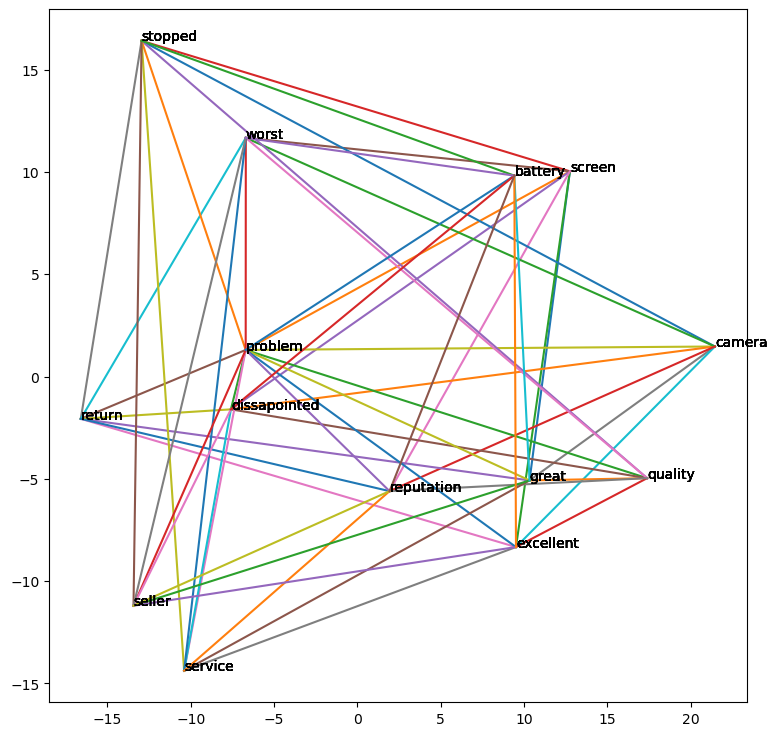

In [88]:
#some visualization
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pairs = [('screen', 'great'),
('screen', 'problem'),
('screen', 'excellent'),
('screen', 'stopped'),
('screen', 'dissapointed'),
('screen', 'worst'),        
('screen', 'reputation'),
('camera', 'great'),         
('camera', 'problem'),
('camera', 'excellent'),
('camera', 'stopped'),
('camera', 'dissapointed'),
('camera', 'worst'),
('camera', 'reputation'),
('return', 'great'),         
('return', 'problem'),
('return', 'excellent'),
('return', 'stopped'),
('return', 'dissapointed'),
('return', 'worst'),
('return', 'reputation'),         
('quality', 'great'),         
('quality', 'problem'),
('quality', 'excellent'),
('quality', 'stopped'),
('quality', 'dissapointed'),
('quality', 'worst'),
('quality', 'reputation'),         
('problem', 'great'),         
('problem', 'problem'),
('problem', 'excellent'),
('problem', 'stopped'),
('problem', 'dissapointed'),
('problem', 'worst'),
('problem', 'reputation'),         
('service', 'great'),         
('service', 'problem'),
('service', 'excellent'),
('service', 'stopped'),
('service', 'dissapointed'),
('service', 'worst'),
('service', 'reputation'),         
('seller', 'great'),         
('seller', 'problem'),
('seller', 'excellent'),
('seller', 'stopped'),
('seller', 'dissapointed'),
('seller', 'worst'),
('seller', 'reputation'),           
('battery', 'great'),         
('battery', 'problem'),
('battery', 'excellent'),
('battery', 'stopped'),
('battery', 'dissapointed'),
('battery', 'worst'),
('battery', 'reputation')]      
n = np.shape(pairs)[0]

difference_matrix = np.array([model.wv.get_vector(a[0])-model.wv.get_vector(a[1]) for a in pairs])

pca = PCA(n_components=n)
pca.fit(difference_matrix)

words=[model.wv.get_vector(word) for word in np.concatenate(pairs)]

coord = pca.fit_transform(words)

print(pca.explained_variance_ratio_)

fig, axes = plt.subplots(figsize=(9,9))
for i in range(n*2):
    plt.annotate(np.concatenate(pairs)[i],(coord[i,0],coord[i,1]))
for i in range (n):
    plt.plot([coord[2*i,0],coord[2*i+1,0]],[coord[2*i,1],coord[2*i+1,1]])
plt.show();


In [89]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation, Flatten
from keras.models import Sequential
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


token = Tokenizer(25718)
token.fit_on_texts(df['Text'])
text = token.texts_to_sequences(df['Text'])

print(text[:2])


[[3], [497]]


In [90]:
X_train, X_test, y_train, y_test = train_test_split(text, df.sentiment, test_size=0.2, stratify=df.sentiment)

In [91]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
vocab_size = len(token.word_index) + 1

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]


In [92]:
y_train.shape

(270516, 3)

In [94]:
# Define the CNN model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPool1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPool1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#the number of epoch was higher, but I reduced to optimal (Unfortunately I did not install early stopp callback)

training_history_1=model.fit(X_train, y_train, epochs=4, batch_size=400, validation_data=(X_test, y_test))

Epoch 1/4
677/677 [==============================] - 68s 101ms/step - loss: 0.4155 - accuracy: 0.8497 - val_loss: 0.3644 - val_accuracy: 0.8704
Epoch 2/4
677/677 [==============================] - 72s 106ms/step - loss: 0.3237 - accuracy: 0.8858 - val_loss: 0.3226 - val_accuracy: 0.8878
Epoch 3/4
677/677 [==============================] - 71s 105ms/step - loss: 0.2669 - accuracy: 0.9086 - val_loss: 0.3058 - val_accuracy: 0.8992
Epoch 4/4
677/677 [==============================] - 68s 100ms/step - loss: 0.2231 - accuracy: 0.9255 - val_loss: 0.3040 - val_accuracy: 0.9028


In [95]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          10319800  
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 19, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 15, 128)           82048     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 384)              

In [96]:
train_acc = training_history_1.history['accuracy']
val_acc = training_history_1.history['val_accuracy']
train_loss=training_history_1.history['loss']
val_loss = training_history_1.history['val_loss']

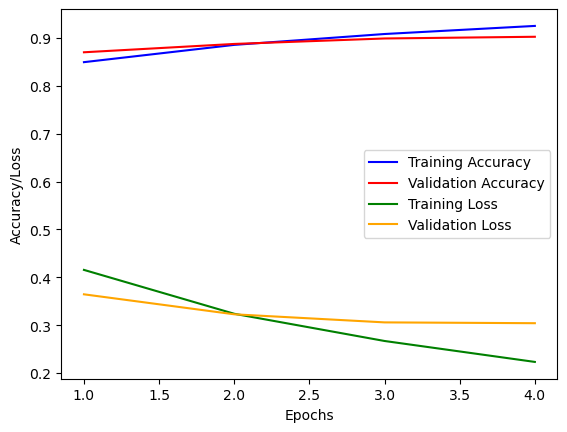

In [97]:
import matplotlib.pyplot as plt
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 5, 1),
         training_history_1.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 5, 1),
         training_history_1.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.plot(np.arange(1 , 5, 1),
        training_history_1.history['loss'], 
        label = 'Training Loss',
         color = 'green')
plt.plot(np.arange(1 , 5, 1),
         training_history_1.history['val_loss'], 
         label = 'Validation Loss',
         color = 'orange')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [98]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report




test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis=1)

print("Classiciation report of Logistic Regression:\n", metrics.classification_report(y_test_class, test_pred_class))
print("Confusion matrix of CNN:\n")

pd.crosstab(y_test_class,test_pred_class, rownames=['Real sentiment'], colnames=['Predicted sentiment'])

2114/2114 [==============================] - 6s 3ms/step
Classiciation report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     16614
           1       0.80      0.34      0.48      5393
           2       0.92      0.97      0.95     45622

    accuracy                           0.90     67629
   macro avg       0.86      0.74      0.77     67629
weighted avg       0.90      0.90      0.89     67629

Confusion matrix of CNN:



Predicted sentiment,0,1,2
Real sentiment,,,
0,14779,245,1590
1,1319,1849,2225
2,980,216,44426


In [11]:
#CNN for binary classification
df.sentiment = df.sentiment.replace(['Positive','Negative','Neutral'],[2,0,1])

df_binary=df.loc[df.sentiment!=1]

model_binary= gensim.models.Word2Vec(window=10, 
                               min_count=5, 
                               workers=4, 
                               alpha=0.01,
                               negative=20,
                               sample=0.0001)
review_text = df_binary['Text'].apply(gensim.utils.simple_preprocess)
model_binary.build_vocab(review_text, progress_per=10000)
model_binary.train(review_text, total_examples=model_binary.corpus_count, epochs=50, report_delay=1)

print(model_binary)

Word2Vec<vocab=24155, vector_size=100, alpha=0.01>


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation, Flatten

from keras.models import Sequential
from sklearn import preprocessing




token = Tokenizer(9726)
token.fit_on_texts(df_binary['Text'])
text = token.texts_to_sequences(df_binary['Text'])

print(text[:2])


[[3], [461]]


In [13]:

X_train, X_test, y_train, y_test = train_test_split(text, df_binary.sentiment, test_size=0.2, stratify=df_binary.sentiment)

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape

(248942, 3)

In [14]:


max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
vocab_size = len(token.word_index) + 1

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    if word in model_binary.wv:
        embedding_matrix[i] = model_binary.wv[word]

In [15]:
y_train.shape
#here it has to be 2 not 3
#this is really strange
#I cannot find the mistake
#in another file everything was correct
#cnn anyway works well

(248942, 3)

In [16]:
df_binary.sentiment.unique()
#here is only two 
#I really do not understand why y_train and y_test has 3

array([2, 0])

In [152]:
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length))
model.add(Conv1D(128, 5, activation='tanh'))

model.add(MaxPool1D(5))
model.add(Conv1D(128, 5, activation='tanh'))

model.add(MaxPool1D(5))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
#because the shape was 3 and not 2 here we have 3 neurons instead of 2
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
training_history_3=model.fit(X_train, y_train, epochs=5, batch_size=250, validation_data=(X_test, y_test))

Epoch 1/5
996/996 [==============================] - 71s 71ms/step - loss: 0.1331 - accuracy: 0.9223 - val_loss: 0.1191 - val_accuracy: 0.9336
Epoch 2/5
996/996 [==============================] - 72s 72ms/step - loss: 0.0913 - accuracy: 0.9516 - val_loss: 0.0973 - val_accuracy: 0.9493
Epoch 3/5
996/996 [==============================] - 73s 73ms/step - loss: 0.0712 - accuracy: 0.9641 - val_loss: 0.0903 - val_accuracy: 0.9557
Epoch 4/5
996/996 [==============================] - 72s 72ms/step - loss: 0.0582 - accuracy: 0.9712 - val_loss: 0.0923 - val_accuracy: 0.9548
Epoch 5/5
996/996 [==============================] - 74s 74ms/step - loss: 0.0489 - accuracy: 0.9763 - val_loss: 0.1012 - val_accuracy: 0.9531


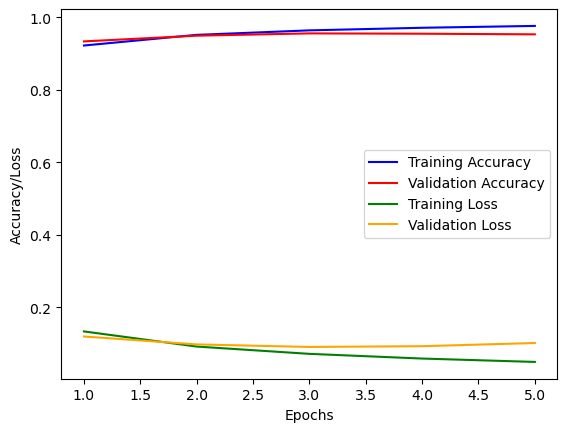

In [154]:
train_acc = training_history_3.history['accuracy']
val_acc = training_history_3.history['val_accuracy']
train_loss=training_history_3.history['loss']
val_loss = training_history_3.history['val_loss']


import matplotlib.pyplot as plt
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 6, 1),
         training_history_3.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 ,6, 1),
         training_history_3.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.plot(np.arange(1 ,6, 1),
        training_history_3.history['loss'], 
        label = 'Training Loss',
         color = 'green')
plt.plot(np.arange(1 ,6, 1),
         training_history_3.history['val_loss'], 
         label = 'Validation Loss',
         color = 'orange')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [155]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis=1)

print("Classiciation report of Logistic Regression:\n", metrics.classification_report(y_test_class, test_pred_class))
print("Confusion matrix of CNN:\n")

pd.crosstab(y_test_class,test_pred_class, rownames=['Real sentiment'], colnames=['Predicted sentiment'])
#here we have two classe _ strange why shape of y_train was 3

1945/1945 [==============================] - 7s 4ms/step
Classiciation report of Logistic Regression:
               precision    recall  f1-score   support

           1       0.89      0.94      0.91     16614
           2       0.98      0.96      0.97     45622

    accuracy                           0.95     62236
   macro avg       0.93      0.95      0.94     62236
weighted avg       0.95      0.95      0.95     62236

Confusion matrix of CNN:



Predicted sentiment,1,2
Real sentiment,,
1,15615,999
2,1921,43701


In [4]:
#some visualization of Word2Vec
df_apple=df.loc[df['Brand Name']=='APPLE']

model_apple= gensim.models.Word2Vec(window=10, 
                               min_count=5, 
                               workers=4, 
                               alpha=0.01,
                               negative=20,
                               sample=0.0001)
review_text = df_apple['Text'].apply(gensim.utils.simple_preprocess)
model_apple.build_vocab(review_text, progress_per=10000)
model_apple.train(review_text, total_examples=model_apple.corpus_count, epochs=50, report_delay=1)

print(model_apple)

Word2Vec<vocab=7027, vector_size=100, alpha=0.01>


In [5]:
df_samsung=df.loc[df['Brand Name']=='SAMSUNG']

model_samsung= gensim.models.Word2Vec(window=10, 
                               min_count=5, 
                               workers=4, 
                               alpha=0.01,
                               negative=20,
                               sample=0.0001)
review_text = df_samsung['Text'].apply(gensim.utils.simple_preprocess)
model_samsung.build_vocab(review_text, progress_per=10000)
model_samsung.train(review_text, total_examples=model_samsung.corpus_count, epochs=50, report_delay=1)

print(model_samsung)

Word2Vec<vocab=8852, vector_size=100, alpha=0.01>


[2.08897392e-01 2.00019648e-01 1.22095704e-01 8.92988047e-02
 8.16017381e-02 7.39183329e-02 5.79542473e-02 4.18771521e-02
 3.42131367e-02 2.84932760e-02 2.14162555e-02 1.86935427e-02
 1.43232454e-02 7.19752488e-03 1.64790986e-31 2.22416205e-32
 9.93205160e-33 8.47207962e-33 7.46264890e-33 5.78176969e-33
 5.13934269e-33 4.67582820e-33 3.50298426e-33 2.18300110e-33
 1.86086874e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33 1.25103747e-33
 1.25103747e-33 1.25103747e-33 1.25103747e-33]


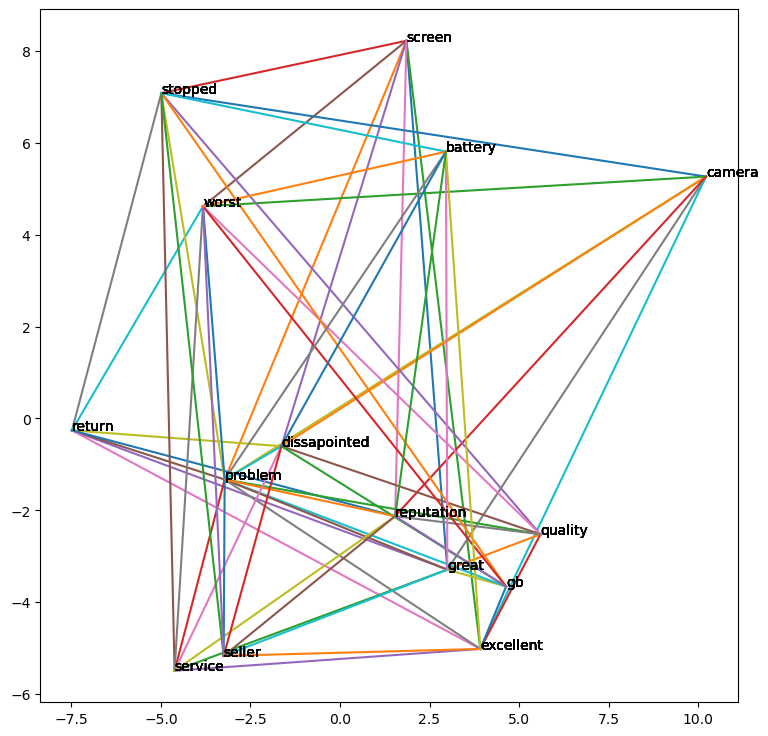

In [6]:
#some visualization
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pairs = [('screen', 'great'),
('screen', 'problem'),
('screen', 'excellent'),
('screen', 'stopped'),
('screen', 'dissapointed'),
('screen', 'worst'),        
('screen', 'reputation'),
('camera', 'great'),         
('camera', 'problem'),
('camera', 'excellent'),
('camera', 'stopped'),
('camera', 'dissapointed'),
('camera', 'worst'),
('camera', 'reputation'),
('return', 'great'),         
('return', 'problem'),
('return', 'excellent'),
('return', 'stopped'),
('return', 'dissapointed'),
('return', 'worst'),
('return', 'reputation'),         
('quality', 'great'),         
('quality', 'problem'),
('quality', 'excellent'),
('quality', 'stopped'),
('quality', 'dissapointed'),
('quality', 'worst'),
('quality', 'reputation'),  
('gb', 'great'),         
('gb', 'problem'),
('gb', 'excellent'),
('gb', 'stopped'),
('gb', 'dissapointed'),
('gb', 'worst'),
('gb', 'reputation'),        
('problem', 'great'),         
('problem', 'problem'),
('problem', 'excellent'),
('problem', 'stopped'),
('problem', 'dissapointed'),
('problem', 'worst'),
('problem', 'reputation'),         
('service', 'great'),         
('service', 'problem'),
('service', 'excellent'),
('service', 'stopped'),
('service', 'dissapointed'),
('service', 'worst'),
('service', 'reputation'),         
('seller', 'great'),         
('seller', 'problem'),
('seller', 'excellent'),
('seller', 'stopped'),
('seller', 'dissapointed'),
('seller', 'worst'),
('seller', 'reputation'),           
('battery', 'great'),         
('battery', 'problem'),
('battery', 'excellent'),
('battery', 'stopped'),
('battery', 'dissapointed'),
('battery', 'worst'),
('battery', 'reputation')]     
n = np.shape(pairs)[0]

difference_matrix = np.array([model_apple.wv.get_vector(a[0])-model_apple.wv.get_vector(a[1]) for a in pairs])

pca = PCA(n_components=n)
pca.fit(difference_matrix)

words=[model_apple.wv.get_vector(word) for word in np.concatenate(pairs)]

coord = pca.fit_transform(words)

print(pca.explained_variance_ratio_)

fig, axes = plt.subplots(figsize=(9,9))
for i in range(n*2):
    plt.annotate(np.concatenate(pairs)[i],(coord[i,0],coord[i,1]))
for i in range (n):
    plt.plot([coord[2*i,0],coord[2*i+1,0]],[coord[2*i,1],coord[2*i+1,1]])
plt.show();


In [ ]:
model.wv.most_similar("plastic")

[2.80982471e-01 1.44995866e-01 1.26001282e-01 9.79084798e-02
 7.93875473e-02 6.99627105e-02 5.55231169e-02 4.36019299e-02
 3.54505439e-02 2.19867094e-02 1.77770102e-02 1.45912664e-02
 6.24139381e-03 5.58967295e-03 2.20032804e-32 1.82058014e-32
 1.07330410e-32 7.58622875e-33 6.64263696e-33 6.55155296e-33
 3.79550893e-33 3.04018667e-33 2.30715838e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33 1.50826252e-33
 1.50826252e-33 1.50826252e-33 1.50826252e-33]


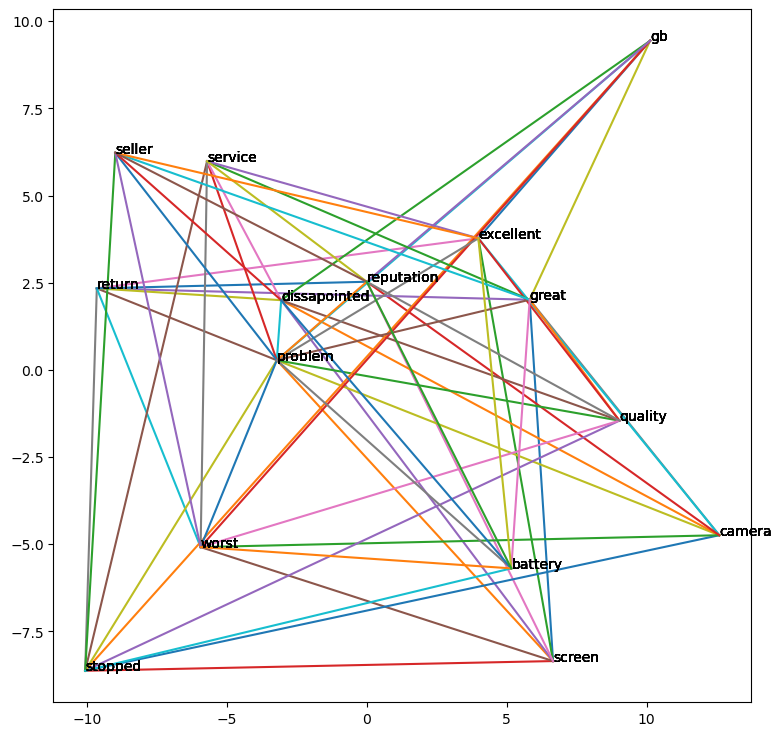

In [7]:
#some visualization
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pairs = [('screen', 'great'),
('screen', 'problem'),
('screen', 'excellent'),
('screen', 'stopped'),
('screen', 'dissapointed'),
('screen', 'worst'),        
('screen', 'reputation'),
('camera', 'great'),         
('camera', 'problem'),
('camera', 'excellent'),
('camera', 'stopped'),
('camera', 'dissapointed'),
('camera', 'worst'),
('camera', 'reputation'),
('return', 'great'),         
('return', 'problem'),
('return', 'excellent'),
('return', 'stopped'),
('return', 'dissapointed'),
('return', 'worst'),
('return', 'reputation'),         
('quality', 'great'),         
('quality', 'problem'),
('quality', 'excellent'),
('quality', 'stopped'),
('quality', 'dissapointed'),
('quality', 'worst'),
('quality', 'reputation'),
('gb', 'great'),         
('gb', 'problem'),
('gb', 'excellent'),
('gb', 'stopped'),
('gb', 'dissapointed'),
('gb', 'worst'),
('gb', 'reputation'),             
('problem', 'great'),         
('problem', 'problem'),
('problem', 'excellent'),
('problem', 'stopped'),
('problem', 'dissapointed'),
('problem', 'worst'),
('problem', 'reputation'),         
('service', 'great'),         
('service', 'problem'),
('service', 'excellent'),
('service', 'stopped'),
('service', 'dissapointed'),
('service', 'worst'),
('service', 'reputation'),         
('seller', 'great'),         
('seller', 'problem'),
('seller', 'excellent'),
('seller', 'stopped'),
('seller', 'dissapointed'),
('seller', 'worst'),
('seller', 'reputation'),           
('battery', 'great'),         
('battery', 'problem'),
('battery', 'excellent'),
('battery', 'stopped'),
('battery', 'dissapointed'),
('battery', 'worst'),
('battery', 'reputation')]       
n = np.shape(pairs)[0]

difference_matrix = np.array([model_samsung.wv.get_vector(a[0])-model_samsung.wv.get_vector(a[1]) for a in pairs])

pca = PCA(n_components=n)
pca.fit(difference_matrix)

words=[model_samsung.wv.get_vector(word) for word in np.concatenate(pairs)]

coord = pca.fit_transform(words)

print(pca.explained_variance_ratio_)

fig, axes = plt.subplots(figsize=(9,9))
for i in range(n*2):
    plt.annotate(np.concatenate(pairs)[i],(coord[i,0],coord[i,1]))
for i in range (n):
    plt.plot([coord[2*i,0],coord[2*i+1,0]],[coord[2*i,1],coord[2*i+1,1]])
plt.show();


## Dense Neural Networks 

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/03/e6/4aef6799badc2693548559bad5b56d56cfe89eada337c815fdfe92175250/xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
